# User Segmentation Analysis

Comprehensive trader segmentation analysis for Polymarket trading data.

## Segmentation Methods:
1. **Behavioral Segmentation** - Volume, frequency, diversity, direction
2. **RFM Analysis** - Recency, Frequency, Monetary value
3. **K-Means Clustering** - Unsupervised segmentation
4. **Visualizations** - Segment distributions and relationships

## Use Cases:
- Identify high-value traders
- Target at-risk traders for re-engagement
- Understand different trading strategies
- Market segmentation for product development


In [16]:
from __future__ import annotations

import warnings
from pathlib import Path
import sys

import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')

# Configure Polars display
pl.Config.set_tbl_rows(25)
pl.Config.set_tbl_cols(-1)
pl.Config.set_tbl_width_chars(1000)

# Configure plotting
plt.style.use('default')
sns.set_palette('husl')

# Add project root to path
PROJECT_ROOT = Path('..').resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from poly_utils import get_markets, PLATFORM_WALLETS

# Helper function to format USD values
def format_usd(value: float) -> str:
    """Format a number as USD currency string."""
    if abs(value) >= 1_000_000:
        return f"${value/1_000_000:,.2f}M"
    elif abs(value) >= 1_000:
        return f"${value/1_000:,.2f}K"
    else:
        return f"${value:,.2f}"

print("✓ Imports loaded")


✓ Imports loaded


## 1. Load Data


In [17]:
# Load markets
markets_df = get_markets(
    main_file=str(PROJECT_ROOT / 'markets.csv'),
    missing_file=str(PROJECT_ROOT / 'missing_markets.csv')
)
print(f"Loaded {len(markets_df):,} markets")

# Load trades - using 10M latest for faster analysis
TRADES_FILE = PROJECT_ROOT / 'processed' / 'latest_10000000_trades.parquet'

if TRADES_FILE.exists():
    trades = pl.read_parquet(TRADES_FILE)
else:
    print("⚠ Latest trades parquet not found, loading full CSV (this may take time)...")
    trades = pl.scan_csv(PROJECT_ROOT / 'processed' / 'trades.csv').collect(streaming=True)

# Ensure timestamp is datetime
if trades['timestamp'].dtype == pl.Utf8:
    trades = trades.with_columns(pl.col('timestamp').str.to_datetime())

print(f"Loaded {len(trades):,} trades")
print(f"Date range: {trades['timestamp'].min()} to {trades['timestamp'].max()}")
print(f"Total volume: ${trades['usd_amount'].sum():,.2f}")


Loaded 178452 markets from /home/junel/random-walk-studio/polymarket/polymarket/markets.csv
Combined total: 177719 unique markets (sorted by createdAt)
Loaded 177,719 markets
Loaded 10,000,000 trades
Date range: 2025-11-13 12:04:14 to 2025-11-20 14:01:29
Total volume: $819,656,447.45


## 2. Create Trader Features


In [18]:
def create_trader_segments(trades_df: pl.DataFrame, markets_df: pl.DataFrame) -> pl.DataFrame:
    """
    Create comprehensive trader segmentation with behavioral, performance, and engagement metrics.
    
    Returns DataFrame with trader features and segment labels.
    """
    from datetime import datetime
    
    # Get current time for recency calculation
    current_time = trades_df['timestamp'].max()
    
    # Calculate comprehensive trader metrics
    trader_features = (
        trades_df
        .group_by('maker')
        .agg(
            # Volume metrics
            pl.col('usd_amount').sum().alias('total_volume'),
            pl.col('usd_amount').mean().alias('avg_trade_size'),
            pl.col('usd_amount').median().alias('median_trade_size'),
            pl.col('usd_amount').std().alias('trade_size_std'),
            pl.col('usd_amount').max().alias('max_trade_size'),
            
            # Frequency metrics
            pl.len().alias('num_trades'),
            pl.col('timestamp').min().alias('first_trade'),
            pl.col('timestamp').max().alias('last_trade'),
            
            # Diversity metrics
            pl.col('market_id').n_unique().alias('unique_markets'),
            pl.col('nonusdc_side').n_unique().alias('unique_sides'),
            
            # Directional metrics
            pl.col('maker_direction').eq('BUY').sum().alias('buy_trades'),
            pl.col('maker_direction').eq('SELL').sum().alias('sell_trades'),
            (pl.when(pl.col('maker_direction') == 'BUY')
               .then(pl.col('usd_amount'))
               .otherwise(0.0)).sum().alias('buy_volume'),
            (pl.when(pl.col('maker_direction') == 'SELL')
               .then(pl.col('usd_amount'))
               .otherwise(0.0)).sum().alias('sell_volume'),
            
            # Price behavior
            pl.col('price').mean().alias('avg_price'),
            pl.col('price').std().alias('price_volatility'),
        )
        .with_columns([
            # Derived metrics
            (pl.col('last_trade') - pl.col('first_trade')).alias('active_period'),
            ((current_time - pl.col('last_trade')).dt.total_days()).alias('days_since_last_trade'),
            ((current_time - pl.col('first_trade')).dt.total_days()).alias('days_since_first_trade'),
        ])
        .with_columns([
            # Division metrics with zero protection
            (pl.col('num_trades') / pl.when(pl.col('unique_markets') > 0).then(pl.col('unique_markets')).otherwise(1)).alias('trades_per_market'),
            (pl.col('buy_trades') / pl.when(pl.col('num_trades') > 0).then(pl.col('num_trades')).otherwise(1)).alias('buy_ratio'),
            ((pl.col('buy_volume') + pl.col('sell_volume')).alias('total_volume_buysell')),
        ])
        .with_columns([
            (pl.col('buy_volume') / pl.when(pl.col('total_volume_buysell') > 0).then(pl.col('total_volume_buysell')).otherwise(1)).alias('buy_volume_ratio'),
            (pl.col('total_volume') / pl.when(pl.col('num_trades') > 0).then(pl.col('num_trades')).otherwise(1)).alias('volume_per_trade'),
            (pl.col('days_since_first_trade') + 1).alias('days_active'),
        ])
        .with_columns([
            # Activity metrics
            (pl.col('num_trades') / pl.when(pl.col('days_active') > 0).then(pl.col('days_active')).otherwise(1)).alias('trades_per_day'),
            (pl.col('total_volume') / pl.when(pl.col('days_active') > 0).then(pl.col('days_active')).otherwise(1)).alias('volume_per_day'),
        ])
        .drop(['total_volume_buysell', 'days_active'])
        .filter(~pl.col('maker').is_in(PLATFORM_WALLETS))
    )
    
    return trader_features


# Create trader segments
print("=== Creating Trader Segments ===")
trader_segments = create_trader_segments(trades, markets_df)

# Clean any inf/nan values using Polars native methods
# Get numeric float columns that might have inf/nan
numeric_cols = []
for col in trader_segments.columns:
    try:
        dtype = trader_segments[col].dtype
        if dtype in [pl.Float64, pl.Float32]:
            numeric_cols.append(col)
    except:
        pass

if numeric_cols:
    # Replace inf and nan with 0 for numeric columns
    # First pass: fill NaN and null
    trader_segments = trader_segments.with_columns([
        pl.col(col).fill_nan(0.0).fill_null(0.0).alias(col)
        for col in numeric_cols
    ])
    # Second pass: handle infinity (values > 1e15 or < -1e15)
    replacements = []
    for col in numeric_cols:
        replacements.append(
            pl.when(pl.col(col).abs() > 1e15)
            .then(pl.lit(0.0))
            .otherwise(pl.col(col))
            .alias(col)
        )
    trader_segments = trader_segments.with_columns(replacements)

print(f"Analyzed {len(trader_segments):,} traders")
print(f"\nColumns: {trader_segments.columns}")
print(f"\nSample data:")
print(trader_segments.head(5))


=== Creating Trader Segments ===
Analyzed 231,034 traders

Columns: ['maker', 'total_volume', 'avg_trade_size', 'median_trade_size', 'trade_size_std', 'max_trade_size', 'num_trades', 'first_trade', 'last_trade', 'unique_markets', 'unique_sides', 'buy_trades', 'sell_trades', 'buy_volume', 'sell_volume', 'avg_price', 'price_volatility', 'active_period', 'days_since_last_trade', 'days_since_first_trade', 'trades_per_market', 'buy_ratio', 'buy_volume_ratio', 'volume_per_trade', 'trades_per_day', 'volume_per_day']

Sample data:
shape: (5, 26)
┌─────────────────────────────────┬───────────────┬────────────────┬───────────────────┬────────────────┬────────────────┬────────────┬─────────────────────┬─────────────────────┬────────────────┬──────────────┬────────────┬─────────────┬──────────────┬──────────────┬───────────┬──────────────────┬────────────────┬───────────────────────┬────────────────────────┬───────────────────┬───────────┬──────────────────┬──────────────────┬────────────────┬────

## 3. Behavioral Segmentation


In [19]:
def apply_behavioral_segmentation(trader_features: pl.DataFrame) -> pl.DataFrame:
    """
    Apply behavioral segmentation based on volume, frequency, diversity, and direction.
    
    Segments:
    - Volume: Whale (>$1M), Shark ($100K-$1M), Active ($10K-$100K), Small (<$10K)
    - Frequency: High Frequency (>100 trades/day), Active (10-100/day), Casual (<10/day)
    - Diversity: Highly Diversified (>100 markets), Diversified (20-100), Focused (<20)
    - Direction: Buyer (>70% buy), Balanced (30-70%), Seller (<30% buy)
    """
    segmented = trader_features.with_columns([
        # Volume segments
        pl.when(pl.col('total_volume') >= 1_000_000).then(pl.lit('Whale'))
          .when(pl.col('total_volume') >= 100_000).then(pl.lit('Shark'))
          .when(pl.col('total_volume') >= 10_000).then(pl.lit('Active'))
          .otherwise(pl.lit('Small'))
          .alias('volume_segment'),
        
        # Frequency segments
        pl.when(pl.col('trades_per_day') >= 100).then(pl.lit('High Frequency'))
          .when(pl.col('trades_per_day') >= 10).then(pl.lit('Active'))
          .otherwise(pl.lit('Casual'))
          .alias('frequency_segment'),
        
        # Diversity segments
        pl.when(pl.col('unique_markets') >= 100).then(pl.lit('Highly Diversified'))
          .when(pl.col('unique_markets') >= 20).then(pl.lit('Diversified'))
          .otherwise(pl.lit('Focused'))
          .alias('diversity_segment'),
        
        # Direction segments
        pl.when(pl.col('buy_ratio') >= 0.7).then(pl.lit('Buyer'))
          .when(pl.col('buy_ratio') <= 0.3).then(pl.lit('Seller'))
          .otherwise(pl.lit('Balanced'))
          .alias('direction_segment'),
    ]).with_columns([
        # Create short frequency label
        pl.when(pl.col('frequency_segment') == 'High Frequency').then(pl.lit('HF'))
          .when(pl.col('frequency_segment') == 'Active').then(pl.lit('Active'))
          .otherwise(pl.lit('Casual'))
          .alias('freq_short'),
        # Create short diversity label
        pl.when(pl.col('diversity_segment') == 'Highly Diversified').then(pl.lit('Diversified'))
          .when(pl.col('diversity_segment') == 'Diversified').then(pl.lit('Mixed'))
          .otherwise(pl.lit('Focused'))
          .alias('div_short'),
    ]).with_columns([
        # Combined behavioral profile (created after short labels exist)
        pl.concat_str([
            pl.col('volume_segment'),
            pl.lit(' - '),
            pl.col('freq_short'),
            pl.lit(' - '),
            pl.col('div_short'),
        ]).alias('behavioral_profile'),
    ]).drop(['freq_short', 'div_short'])
    
    return segmented


# Apply behavioral segmentation
trader_segments = apply_behavioral_segmentation(trader_segments)

print("=== Behavioral Segmentation Summary ===")
print("\nVolume Segments:")
volume_summary = trader_segments.group_by('volume_segment').agg([
    pl.len().alias('count'),
    pl.col('total_volume').sum().alias('total_volume'),
    pl.col('num_trades').sum().alias('total_trades'),
]).sort('total_volume', descending=True)
display_volume = volume_summary.with_columns([
    pl.col('total_volume').map_elements(lambda x: format_usd(x), return_dtype=pl.Utf8).alias('total_volume_usd'),
])
print(display_volume)

print("\nFrequency Segments:")
print(trader_segments.group_by('frequency_segment').agg([
    pl.len().alias('count'),
    pl.col('trades_per_day').mean().alias('avg_trades_per_day'),
]).sort('count', descending=True))

print("\nDiversity Segments:")
print(trader_segments.group_by('diversity_segment').agg([
    pl.len().alias('count'),
    pl.col('unique_markets').mean().alias('avg_markets'),
]).sort('count', descending=True))

print("\nDirection Segments:")
print(trader_segments.group_by('direction_segment').agg([
    pl.len().alias('count'),
    pl.col('buy_ratio').mean().alias('avg_buy_ratio'),
]).sort('count', descending=True))


=== Behavioral Segmentation Summary ===

Volume Segments:
shape: (4, 5)
┌────────────────┬────────┬──────────────┬──────────────┬──────────────────┐
│ volume_segment ┆ count  ┆ total_volume ┆ total_trades ┆ total_volume_usd │
│ ---            ┆ ---    ┆ ---          ┆ ---          ┆ ---              │
│ str            ┆ u32    ┆ f64          ┆ u32          ┆ str              │
╞════════════════╪════════╪══════════════╪══════════════╪══════════════════╡
│ Whale          ┆ 116    ┆ 2.8736e8     ┆ 2266673      ┆ $287.36M         │
│ Shark          ┆ 832    ┆ 2.2713e8     ┆ 2240953      ┆ $227.13M         │
│ Active         ┆ 7295   ┆ 1.8779e8     ┆ 2276306      ┆ $187.79M         │
│ Small          ┆ 222791 ┆ 1.1737e8     ┆ 3216068      ┆ $117.37M         │
└────────────────┴────────┴──────────────┴──────────────┴──────────────────┘

Frequency Segments:
shape: (3, 3)
┌───────────────────┬────────┬────────────────────┐
│ frequency_segment ┆ count  ┆ avg_trades_per_day │
│ ---              

## 4. RFM Analysis (Recency, Frequency, Monetary)


In [20]:
def apply_rfm_segmentation(trader_features: pl.DataFrame) -> pl.DataFrame:
    """
    Apply RFM (Recency, Frequency, Monetary) segmentation.
    
    RFM Scores (1-5 scale):
    - Recency: Days since last trade (1=recent, 5=old)
    - Frequency: Number of trades (1=low, 5=high)
    - Monetary: Total volume (1=low, 5=high)
    """
    rfm = trader_features.with_columns([
        # Recency score (inverse - recent is better)
        pl.when(pl.col('days_since_last_trade') <= 1).then(pl.lit(5))
          .when(pl.col('days_since_last_trade') <= 3).then(pl.lit(4))
          .when(pl.col('days_since_last_trade') <= 7).then(pl.lit(3))
          .when(pl.col('days_since_last_trade') <= 14).then(pl.lit(2))
          .otherwise(pl.lit(1))
          .alias('recency_score'),
        
        # Frequency score
        pl.when(pl.col('num_trades') >= 1000).then(pl.lit(5))
          .when(pl.col('num_trades') >= 500).then(pl.lit(4))
          .when(pl.col('num_trades') >= 100).then(pl.lit(3))
          .when(pl.col('num_trades') >= 50).then(pl.lit(2))
          .otherwise(pl.lit(1))
          .alias('frequency_score'),
        
        # Monetary score
        pl.when(pl.col('total_volume') >= 1_000_000).then(pl.lit(5))
          .when(pl.col('total_volume') >= 100_000).then(pl.lit(4))
          .when(pl.col('total_volume') >= 10_000).then(pl.lit(3))
          .when(pl.col('total_volume') >= 1_000).then(pl.lit(2))
          .otherwise(pl.lit(1))
          .alias('monetary_score'),
    ]).with_columns([
        # RFM score (concatenated)
        pl.concat_str([
            pl.col('recency_score').cast(pl.Utf8),
            pl.col('frequency_score').cast(pl.Utf8),
            pl.col('monetary_score').cast(pl.Utf8),
        ]).alias('rfm_score'),
        
        # RFM segment
        pl.when(
            (pl.col('recency_score') >= 4) & 
            (pl.col('frequency_score') >= 4) & 
            (pl.col('monetary_score') >= 4)
        ).then(pl.lit('Champions'))
        .when(
            (pl.col('recency_score') >= 4) & 
            (pl.col('frequency_score') <= 2) & 
            (pl.col('monetary_score') >= 4)
        ).then(pl.lit('Big Spenders'))
        .when(
            (pl.col('recency_score') <= 2) & 
            (pl.col('frequency_score') >= 4) & 
            (pl.col('monetary_score') >= 4)
        ).then(pl.lit('At Risk'))
        .when(
            (pl.col('recency_score') <= 2) & 
            (pl.col('frequency_score') <= 2) & 
            (pl.col('monetary_score') <= 2)
        ).then(pl.lit('Lost'))
        .when(
            (pl.col('recency_score') >= 3) & 
            (pl.col('frequency_score') >= 3)
        ).then(pl.lit('Loyal'))
        .otherwise(pl.lit('Regular'))
        .alias('rfm_segment'),
    ])
    
    return rfm


# Apply RFM segmentation
trader_segments = apply_rfm_segmentation(trader_segments)

print("=== RFM Segmentation Summary ===")
print("\nRFM Segments:")
rfm_summary = trader_segments.group_by('rfm_segment').agg([
    pl.len().alias('count'),
    pl.col('total_volume').sum().alias('total_volume'),
    pl.col('num_trades').sum().alias('total_trades'),
    pl.col('days_since_last_trade').mean().alias('avg_days_since_last'),
]).sort('count', descending=True)

display_rfm = rfm_summary.with_columns([
    pl.col('total_volume').map_elements(lambda x: format_usd(x), return_dtype=pl.Utf8).alias('total_volume_usd'),
])
print(display_rfm)

print("\nTop RFM Scores:")
print(trader_segments.group_by('rfm_score').agg([
    pl.len().alias('count'),
]).sort('count', descending=True).head(10))


=== RFM Segmentation Summary ===

RFM Segments:
shape: (4, 6)
┌──────────────┬────────┬──────────────┬──────────────┬─────────────────────┬──────────────────┐
│ rfm_segment  ┆ count  ┆ total_volume ┆ total_trades ┆ avg_days_since_last ┆ total_volume_usd │
│ ---          ┆ ---    ┆ ---          ┆ ---          ┆ ---                 ┆ ---              │
│ str          ┆ u32    ┆ f64          ┆ u32          ┆ f64                 ┆ str              │
╞══════════════╪════════╪══════════════╪══════════════╪═════════════════════╪══════════════════╡
│ Regular      ┆ 223420 ┆ 2.1593e8     ┆ 1701565      ┆ 2.088049            ┆ $215.93M         │
│ Loyal        ┆ 6998   ┆ 1.9138e8     ┆ 3923615      ┆ 0.497285            ┆ $191.38M         │
│ Champions    ┆ 501    ┆ 3.8732e8     ┆ 4369478      ┆ 0.105788            ┆ $387.32M         │
│ Big Spenders ┆ 115    ┆ 2.5022e7     ┆ 5342         ┆ 0.747826            ┆ $25.02M          │
└──────────────┴────────┴──────────────┴──────────────┴──────────

## 5. K-Means Clustering


In [21]:
def apply_clustering_segmentation(trader_features: pl.DataFrame, n_clusters: int = 5) -> pl.DataFrame:
    """
    Apply K-means clustering for unsupervised segmentation.
    
    Features used for clustering:
    - Log(total_volume)
    - Log(num_trades)
    - unique_markets (normalized)
    - buy_ratio
    - trades_per_day
    - days_since_last_trade (normalized)
    """
    # Prepare features for clustering using Polars
    features_df = trader_features.select([
        pl.col('total_volume'),
        pl.col('num_trades'),
        pl.col('unique_markets'),
        pl.col('buy_ratio'),
        pl.col('trades_per_day'),
        pl.col('days_since_last_trade'),
    ])
    
    # Clean data - handle inf/nan
    numeric_cols = ['total_volume', 'num_trades', 'unique_markets', 'buy_ratio', 'trades_per_day', 'days_since_last_trade']
    features_df = features_df.with_columns([
        pl.col(col).fill_nan(0.0).fill_null(0.0).alias(col)
        for col in numeric_cols
    ])
    features_df = features_df.with_columns([
        pl.when(pl.col(col).abs() > 1e15).then(pl.lit(0.0)).otherwise(pl.col(col)).alias(col)
        for col in numeric_cols
    ])
    
    # Extract as numpy arrays
    total_volume = np.array(features_df['total_volume'].to_list())
    num_trades = np.array(features_df['num_trades'].to_list())
    unique_markets = np.array(features_df['unique_markets'].to_list())
    buy_ratio = np.array(features_df['buy_ratio'].to_list())
    trades_per_day = np.array(features_df['trades_per_day'].to_list())
    days_since_last = np.array(features_df['days_since_last_trade'].to_list())
    
    # Log transform volume and trades for better clustering
    log_volume = np.log1p(total_volume)
    log_trades = np.log1p(num_trades)
    
    # Stack features for clustering
    cluster_features = np.column_stack([
        log_volume, log_trades, unique_markets, 
        buy_ratio, trades_per_day, days_since_last
    ])
    
    # Standardize features
    scaler = StandardScaler()
    cluster_features_scaled = scaler.fit_transform(cluster_features)
    
    # Apply K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(cluster_features_scaled)
    
    # Add cluster labels back to dataframe using Polars
    # Create a temporary index column for joining
    trader_features_with_idx = trader_features.with_row_index('_idx')
    # Create cluster labels DataFrame
    cluster_df = pl.DataFrame({
        '_idx': range(len(cluster_labels)),
        'cluster': [str(c) for c in cluster_labels]
    })
    # Join to add cluster labels
    result = trader_features_with_idx.join(cluster_df, on='_idx').drop('_idx')
    
    # Characterize clusters
    cluster_chars = result.group_by('cluster').agg([
        pl.len().alias('count'),
        pl.col('total_volume').mean().alias('avg_volume'),
        pl.col('num_trades').mean().alias('avg_trades'),
        pl.col('unique_markets').mean().alias('avg_markets'),
        pl.col('buy_ratio').mean().alias('avg_buy_ratio'),
        pl.col('trades_per_day').mean().alias('avg_trades_per_day'),
    ]).sort('avg_volume', descending=True)
    
    print("=== Cluster Characteristics ===")
    display_clusters = cluster_chars.with_columns([
        pl.col('avg_volume').map_elements(lambda x: format_usd(x), return_dtype=pl.Utf8).alias('avg_volume_usd'),
    ])
    print(display_clusters)
    
    return result


# Apply clustering (use sample for faster computation if needed)
print("=== Applying K-Means Clustering ===")
try:
    if len(trader_segments) > 10000:
        print(f"Large dataset ({len(trader_segments):,} traders). Sampling 10,000 for clustering...")
        sample_for_clustering = trader_segments.sample(10000, seed=42)
        clustered_sample = apply_clustering_segmentation(sample_for_clustering, n_clusters=5)
        print("\nNote: Clustering applied to sample. Use full dataset for production analysis.")
        # Add cluster column to full dataset (set to None for non-sampled traders)
        trader_segments = trader_segments.with_columns([
            pl.lit(None).cast(pl.Utf8).alias('cluster')
        ])
    else:
        trader_segments = apply_clustering_segmentation(trader_segments, n_clusters=5)
except Exception as e:
    print(f"⚠ Clustering failed: {e}")
    print("Continuing without cluster labels...")
    trader_segments = trader_segments.with_columns([
        pl.lit(None).cast(pl.Utf8).alias('cluster')
    ])


=== Applying K-Means Clustering ===
Large dataset (231,034 traders). Sampling 10,000 for clustering...
=== Cluster Characteristics ===
shape: (5, 8)
┌─────────┬───────┬───────────────┬────────────┬─────────────┬───────────────┬────────────────────┬────────────────┐
│ cluster ┆ count ┆ avg_volume    ┆ avg_trades ┆ avg_markets ┆ avg_buy_ratio ┆ avg_trades_per_day ┆ avg_volume_usd │
│ ---     ┆ ---   ┆ ---           ┆ ---        ┆ ---         ┆ ---           ┆ ---                ┆ ---            │
│ str     ┆ u32   ┆ f64           ┆ f64        ┆ f64         ┆ f64           ┆ f64                ┆ str            │
╞═════════╪═══════╪═══════════════╪════════════╪═════════════╪═══════════════╪════════════════════╪════════════════╡
│ 4       ┆ 5     ┆ 999538.614459 ┆ 55566.2    ┆ 1327.8      ┆ 0.833522      ┆ 6945.775           ┆ $999.54K       │
│ 1       ┆ 1793  ┆ 16144.785706  ┆ 171.625767 ┆ 29.496375   ┆ 0.754393      ┆ 26.36481           ┆ $16.14K        │
│ 2       ┆ 1820  ┆ 705.278346  

## 6. Visualizations


=== Creating Segmentation Visualizations ===
Note: Run clustering first to see full visualizations


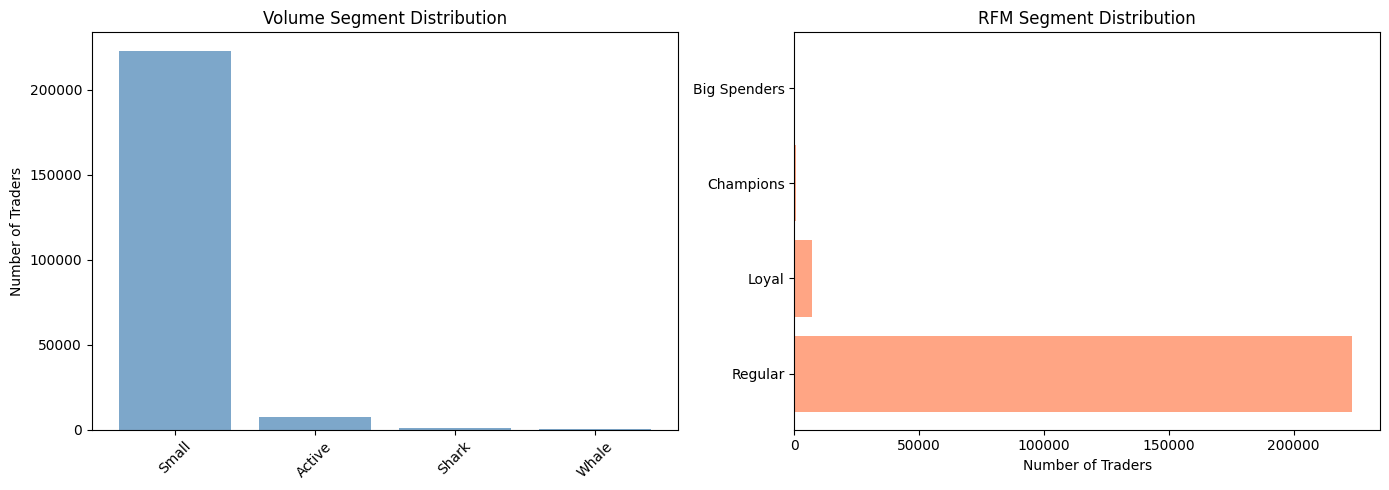

In [22]:
def visualize_segmentation(trader_segments: pl.DataFrame):
    """
    Create visualizations for trader segmentation.
    """
    # Extract data using Polars operations
    # 1. Volume segments distribution
    volume_counts_df = trader_segments.group_by('volume_segment').agg(pl.len().alias('count')).sort('count', descending=True)
    volume_segments = volume_counts_df['volume_segment'].to_list()
    volume_counts = volume_counts_df['count'].to_list()
    
    # 2. RFM segments
    rfm_counts_df = trader_segments.group_by('rfm_segment').agg(pl.len().alias('count')).sort('count', descending=True)
    rfm_segments = rfm_counts_df['rfm_segment'].to_list()
    rfm_counts = rfm_counts_df['count'].to_list()
    
    # 3. Volume vs Frequency scatter data
    plot_data_df = trader_segments.filter(
        (pl.col('trades_per_day') > 0) & (pl.col('total_volume') > 0)
    )
    
    # 4. Diversity vs Volume data
    plot_data2_df = trader_segments.filter(
        (pl.col('unique_markets') > 0) & (pl.col('total_volume') > 0)
    )
    
    # 5. Buy ratio by segment
    direction_segments_df = trader_segments.group_by('direction_segment').agg(
        pl.col('buy_ratio').mean().alias('avg_buy_ratio')
    ).sort('avg_buy_ratio')
    
    # 6. Recency data
    recency_data_df = trader_segments.filter(pl.col('days_since_last_trade') > 0)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Volume segments distribution
    ax1 = axes[0, 0]
    ax1.bar(volume_segments, volume_counts, color='steelblue', alpha=0.7)
    ax1.set_title('Volume Segment Distribution')
    ax1.set_xlabel('Segment')
    ax1.set_ylabel('Number of Traders')
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. RFM segments
    ax2 = axes[0, 1]
    ax2.barh(rfm_segments, rfm_counts, color='coral', alpha=0.7)
    ax2.set_title('RFM Segment Distribution')
    ax2.set_xlabel('Number of Traders')
    
    # 3. Volume vs Frequency scatter
    ax3 = axes[0, 2]
    if len(plot_data_df) > 0:
        trades_per_day = plot_data_df['trades_per_day'].to_list()
        total_volume = plot_data_df['total_volume'].to_list()
        volume_seg = plot_data_df['volume_segment'].to_list()
        # Create numeric codes for coloring
        seg_map = {seg: i for i, seg in enumerate(set(volume_seg))}
        colors = [seg_map[s] for s in volume_seg]
        ax3.scatter(trades_per_day, total_volume, c=colors, alpha=0.3, s=10, cmap='viridis')
        ax3.set_xscale('log')
        ax3.set_yscale('log')
    ax3.set_xlabel('Trades per Day')
    ax3.set_ylabel('Total Volume (USD)')
    ax3.set_title('Volume vs Frequency')
    ax3.grid(True, alpha=0.3)
    
    # 4. Diversity vs Volume
    ax4 = axes[1, 0]
    if len(plot_data2_df) > 0:
        unique_markets = plot_data2_df['unique_markets'].to_list()
        total_vol = plot_data2_df['total_volume'].to_list()
        div_seg = plot_data2_df['diversity_segment'].to_list()
        div_map = {seg: i for i, seg in enumerate(set(div_seg))}
        div_colors = [div_map[s] for s in div_seg]
        ax4.scatter(unique_markets, total_vol, c=div_colors, alpha=0.3, s=10, cmap='plasma')
        ax4.set_xscale('log')
        ax4.set_yscale('log')
    ax4.set_xlabel('Unique Markets')
    ax4.set_ylabel('Total Volume (USD)')
    ax4.set_title('Diversity vs Volume')
    ax4.grid(True, alpha=0.3)
    
    # 5. Buy ratio distribution by segment
    ax5 = axes[1, 1]
    dir_segments = direction_segments_df['direction_segment'].to_list()
    buy_ratios = direction_segments_df['avg_buy_ratio'].to_list()
    ax5.barh(dir_segments, buy_ratios, color='green', alpha=0.7)
    ax5.set_title('Average Buy Ratio by Direction Segment')
    ax5.set_xlabel('Buy Ratio')
    ax5.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
    
    # 6. Recency distribution
    ax6 = axes[1, 2]
    if len(recency_data_df) > 0:
        recency_data = recency_data_df['days_since_last_trade'].to_list()
        ax6.hist(recency_data, bins=50, color='purple', alpha=0.7, edgecolor='black')
        ax6.set_xscale('log')
    ax6.set_xlabel('Days Since Last Trade')
    ax6.set_ylabel('Number of Traders')
    ax6.set_title('Recency Distribution')
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# Create visualizations
print("=== Creating Segmentation Visualizations ===")
has_clusters = 'cluster' in trader_segments.columns
if has_clusters:
    try:
        null_count = trader_segments['cluster'].null_count()
        has_valid_clusters = null_count < len(trader_segments)
    except:
        has_valid_clusters = False
else:
    has_valid_clusters = False

if has_valid_clusters:
    visualize_segmentation(trader_segments)
else:
    print("Note: Run clustering first to see full visualizations")
    # Still show basic visualizations using Polars
    volume_counts_df = trader_segments.group_by('volume_segment').agg(pl.len().alias('count')).sort('count', descending=True)
    rfm_counts_df = trader_segments.group_by('rfm_segment').agg(pl.len().alias('count')).sort('count', descending=True)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].bar(volume_counts_df['volume_segment'].to_list(), volume_counts_df['count'].to_list(), color='steelblue', alpha=0.7)
    axes[0].set_title('Volume Segment Distribution')
    axes[0].set_ylabel('Number of Traders')
    axes[0].tick_params(axis='x', rotation=45)
    
    axes[1].barh(rfm_counts_df['rfm_segment'].to_list(), rfm_counts_df['count'].to_list(), color='coral', alpha=0.7)
    axes[1].set_title('RFM Segment Distribution')
    axes[1].set_xlabel('Number of Traders')
    
    plt.tight_layout()
    plt.show()


## 7. Summary and Export


## 8. Parlay Protocol UA Strategy Segmentation

Advanced segmentation for user acquisition strategy focusing on:
- **High-signal traders** (non-toxic flow generators)
- **Toxicity detection** (bonus hunters, arbitrageurs)
- **MM profitability** (traders profitable for market makers)
- **AppToken responsiveness** (traders likely to respond to incentives)
- **Referral potential** (affiliate/word-of-mouth candidates)
- **Churn risk & reactivation** (retention opportunities)


In [23]:
def create_ua_strategy_segments(trader_segments: pl.DataFrame, trades_df: pl.DataFrame) -> pl.DataFrame:
    """
    Create UA strategy-specific segments for parlay protocol.
    
    Segments:
    1. Signal Quality: High-signal vs low-signal traders
    2. Toxicity: Bonus hunters, arbitrageurs, toxic flow
    3. MM Profitability: Traders profitable for market makers
    4. AppToken Responsiveness: Likely to respond to incentives
    5. Referral Potential: Good affiliate/referral candidates
    6. Churn Risk: Retention opportunities
    """
    from datetime import datetime
    
    # Calculate volatility threshold for toxicity detection
    volatility_90th = trader_segments['price_volatility'].quantile(0.9) if 'price_volatility' in trader_segments.columns else 1.0
    
    # Start with base dataframe and add columns one by one to avoid nesting issues
    df = trader_segments
    
    # 1. Signal Quality Segmentation - Step by step
    # Safe division for cv_ratio
    df = df.with_columns([
        pl.when(pl.col('avg_trade_size') > 0).then(pl.col('avg_trade_size')).otherwise(1.0).alias('_avg_trade_size_safe')
    ])
    
    # Calculate cv_ratio
    df = df.with_columns([
        (pl.col('trade_size_std') / pl.col('_avg_trade_size_safe')).alias('_cv_ratio')
    ])
    
    # Normalize values
    df = df.with_columns([
        (pl.col('unique_markets') / 10.0).alias('_markets_norm'),
        (pl.col('trades_per_day') / 10.0).alias('_trades_norm'),
        (pl.col('buy_ratio') - 0.5).alias('_buy_ratio_dev'),
    ])
    
    # Calculate absolute deviation
    df = df.with_columns([
        (pl.col('_buy_ratio_dev').abs() * 2).alias('_buy_ratio_dev_abs')
    ])
    
    # Balance score
    df = df.with_columns([
        (1.0 - pl.col('_buy_ratio_dev_abs')).alias('_balance_score')
    ])
    
    # Cap values
    df = df.with_columns([
        pl.when(pl.col('_cv_ratio') > 100).then(pl.lit(100.0)).otherwise(pl.col('_cv_ratio')).alias('_cv_ratio_capped'),
        pl.when(pl.col('_markets_norm') > 1.0).then(pl.lit(1.0)).otherwise(pl.col('_markets_norm')).alias('_markets_norm_capped'),
        pl.when(pl.col('_trades_norm') > 1.0).then(pl.lit(1.0)).otherwise(pl.col('_trades_norm')).alias('_trades_norm_capped'),
    ])
    
    # Calculate score components
    df = df.with_columns([
        ((100 - pl.col('_cv_ratio_capped')) * 0.2).alias('_vol_consistency'),
        (pl.col('_markets_norm_capped') * 30).alias('_diversity_comp'),
        (pl.col('_balance_score') * 30).alias('_balance_comp'),
        (pl.col('_trades_norm_capped') * 20).alias('_activity_comp'),
    ])
    
    # Combine to get signal quality score
    df = df.with_columns([
        (pl.col('_vol_consistency') + pl.col('_diversity_comp') + pl.col('_balance_comp') + pl.col('_activity_comp')).alias('signal_quality_score')
    ])
    
    # Toxicity indicators - calculate separately
    df = df.with_columns([
        pl.when(
            (pl.col('volume_per_day') > 10000) & 
            (pl.col('unique_markets') < 5) &
            (pl.col('days_since_first_trade') < 7)
        ).then(pl.lit(True)).otherwise(pl.lit(False)).alias('potential_bonus_hunter')
    ])
    
    df = df.with_columns([
        pl.when(
            (pl.col('trades_per_day') > 50) &
            (pl.col('avg_trade_size') < 100) &
            (pl.col('unique_markets') > 20)
        ).then(pl.lit(True)).otherwise(pl.lit(False)).alias('potential_arbitrageur')
    ])
    
    df = df.with_columns([
        pl.when(
            ((pl.col('buy_ratio') < 0.1) | (pl.col('buy_ratio') > 0.9)) &
            (pl.col('price_volatility') > volatility_90th)
        ).then(pl.lit(True)).otherwise(pl.lit(False)).alias('potential_toxic_flow')
    ])
    
    # Signal quality segment
    df = df.with_columns([
        pl.when(pl.col('signal_quality_score') >= 70).then(pl.lit('High Signal'))
        .when(pl.col('signal_quality_score') >= 40).then(pl.lit('Medium Signal'))
        .otherwise(pl.lit('Low Signal'))
        .alias('signal_quality_segment')
    ])
    
    # Toxicity segment
    df = df.with_columns([
        pl.when(
            pl.col('potential_bonus_hunter') | 
            pl.col('potential_arbitrageur') | 
            pl.col('potential_toxic_flow')
        ).then(pl.lit('Toxic')).otherwise(pl.lit('Non-Toxic')).alias('toxicity_segment')
    ])
    
    signal_segments = df
    
    # 2. MM Profitability Proxy
    df = signal_segments.with_columns([
        (pl.col('total_volume') / 100000).alias('_vol_norm_mm'),
        (pl.col('trades_per_day') / 5.0).alias('_trades_norm_mm'),
        (pl.col('buy_ratio') - 0.5).alias('_buy_dev_mm'),
    ])
    
    df = df.with_columns([
        (pl.col('_buy_dev_mm').abs() * 2).alias('_buy_dev_abs_mm')
    ])
    
    df = df.with_columns([
        (1.0 - pl.col('_buy_dev_abs_mm')).alias('_balance_mm')
    ])
    
    df = df.with_columns([
        pl.when(pl.col('_vol_norm_mm') > 1.0).then(pl.lit(1.0)).otherwise(pl.col('_vol_norm_mm')).alias('_vol_capped_mm'),
        pl.when(pl.col('_cv_ratio') > 1.0).then(pl.lit(1.0)).otherwise(pl.col('_cv_ratio')).alias('_cv_capped_mm'),
        pl.when(pl.col('_trades_norm_mm') > 1.0).then(pl.lit(1.0)).otherwise(pl.col('_trades_norm_mm')).alias('_trades_capped_mm'),
    ])
    
    df = df.with_columns([
        (pl.col('_vol_capped_mm') * 30).alias('_vol_comp_mm'),
        (pl.col('_balance_mm') * 30).alias('_bal_comp_mm'),
        ((1.0 - pl.col('_cv_capped_mm')) * 20).alias('_cons_comp_mm'),
        (pl.col('_trades_capped_mm') * 20).alias('_act_comp_mm'),
    ])
    
    df = df.with_columns([
        (pl.col('_vol_comp_mm') + pl.col('_bal_comp_mm') + pl.col('_cons_comp_mm') + pl.col('_act_comp_mm')).alias('mm_profitability_score')
    ])
    
    df = df.with_columns([
        pl.when(pl.col('mm_profitability_score') >= 70).then(pl.lit('Highly Profitable'))
        .when(pl.col('mm_profitability_score') >= 40).then(pl.lit('Profitable'))
        .otherwise(pl.lit('Marginal'))
        .alias('mm_profitability_segment')
    ])
    
    mm_profitability = df
    
    # 3. AppToken Responsiveness
    df = mm_profitability.with_columns([
        (pl.col('days_since_last_trade') / 30.0).alias('_days_norm_at'),
        (pl.col('total_volume') / 50000).alias('_vol_norm_at'),
        (pl.col('trades_per_day') / 3.0).alias('_trades_norm_at'),
        pl.when(pl.col('total_volume') < 1000000).then(1.0).otherwise(0.5).alias('_whale_factor'),
    ])
    
    df = df.with_columns([
        pl.when(pl.col('_days_norm_at') > 1.0).then(pl.lit(1.0)).otherwise(pl.col('_days_norm_at')).alias('_days_capped_at'),
        pl.when(pl.col('_vol_norm_at') > 1.0).then(pl.lit(1.0)).otherwise(pl.col('_vol_norm_at')).alias('_vol_capped_at'),
        pl.when(pl.col('_trades_norm_at') > 1.0).then(pl.lit(1.0)).otherwise(pl.col('_trades_norm_at')).alias('_trades_capped_at'),
    ])
    
    df = df.with_columns([
        ((1.0 - pl.col('_days_capped_at')) * 25).alias('_recency_at'),
        (pl.col('_vol_capped_at') * 25).alias('_vol_comp_at'),
        (pl.col('_trades_capped_at') * 25).alias('_freq_comp_at'),
        (pl.col('_whale_factor') * 25).alias('_whale_comp_at'),
    ])
    
    df = df.with_columns([
        (pl.col('_recency_at') + pl.col('_vol_comp_at') + pl.col('_freq_comp_at') + pl.col('_whale_comp_at')).alias('apptoken_responsiveness_score')
    ])
    
    df = df.with_columns([
        pl.when(pl.col('apptoken_responsiveness_score') >= 70).then(pl.lit('Highly Responsive'))
        .when(pl.col('apptoken_responsiveness_score') >= 40).then(pl.lit('Responsive'))
        .otherwise(pl.lit('Low Responsiveness'))
        .alias('apptoken_responsiveness_segment')
    ])
    
    apptoken_responsive = df
    
    # 4. Referral Potential
    df = apptoken_responsive.with_columns([
        (pl.col('trades_per_day') / 2.0).alias('_trades_norm_ref'),
        (pl.col('unique_markets') / 15.0).alias('_markets_norm_ref'),
        (pl.col('days_since_last_trade') / 14.0).alias('_days_norm_ref'),
        pl.when(
            (pl.col('total_volume') >= 10000) & (pl.col('total_volume') <= 500000)
        ).then(1.0).otherwise(0.5).alias('_vol_factor_ref'),
    ])
    
    df = df.with_columns([
        pl.when(pl.col('_trades_norm_ref') > 1.0).then(pl.lit(1.0)).otherwise(pl.col('_trades_norm_ref')).alias('_trades_capped_ref'),
        pl.when(pl.col('_markets_norm_ref') > 1.0).then(pl.lit(1.0)).otherwise(pl.col('_markets_norm_ref')).alias('_markets_capped_ref'),
        pl.when(pl.col('_days_norm_ref') > 1.0).then(pl.lit(1.0)).otherwise(pl.col('_days_norm_ref')).alias('_days_capped_ref'),
    ])
    
    df = df.with_columns([
        (pl.col('_trades_capped_ref') * 30).alias('_eng_comp_ref'),
        (pl.col('_markets_capped_ref') * 30).alias('_div_comp_ref'),
        ((1.0 - pl.col('_days_capped_ref')) * 20).alias('_act_comp_ref'),
        (pl.col('_vol_factor_ref') * 20).alias('_vol_comp_ref'),
    ])
    
    df = df.with_columns([
        (pl.col('_eng_comp_ref') + pl.col('_div_comp_ref') + pl.col('_act_comp_ref') + pl.col('_vol_comp_ref')).alias('referral_potential_score')
    ])
    
    df = df.with_columns([
        pl.when(pl.col('referral_potential_score') >= 70).then(pl.lit('High Potential'))
        .when(pl.col('referral_potential_score') >= 40).then(pl.lit('Medium Potential'))
        .otherwise(pl.lit('Low Potential'))
        .alias('referral_potential_segment')
    ])
    
    referral_potential = df
    
    # 5. Churn Risk & Reactivation
    df = referral_potential.with_columns([
        (pl.col('days_since_last_trade') / 30.0).alias('_days_norm_churn'),
        pl.when(pl.col('trades_per_day') < 0.1).then(1.0).otherwise(0.0).alias('_low_activity'),
        pl.when(pl.col('total_volume') < 1000).then(1.0).otherwise(0.0).alias('_low_volume'),
    ])
    
    df = df.with_columns([
        pl.when(pl.col('_days_norm_churn') > 1.0).then(pl.lit(1.0)).otherwise(pl.col('_days_norm_churn')).alias('_days_capped_churn')
    ])
    
    df = df.with_columns([
        (pl.col('_days_capped_churn') * 40).alias('_recency_risk'),
        (pl.col('_low_activity') * 30).alias('_activity_risk'),
        (pl.col('_low_volume') * 30).alias('_volume_risk'),
    ])
    
    df = df.with_columns([
        (pl.col('_recency_risk') + pl.col('_activity_risk') + pl.col('_volume_risk')).alias('churn_risk_score')
    ])
    
    df = df.with_columns([
        pl.when(pl.col('churn_risk_score') >= 70).then(pl.lit('High Risk'))
        .when(pl.col('churn_risk_score') >= 40).then(pl.lit('Medium Risk'))
        .otherwise(pl.lit('Low Risk'))
        .alias('churn_risk_segment')
    ])
    
    df = df.with_columns([
        pl.when(
            (pl.col('days_since_last_trade') >= 7) &
            (pl.col('days_since_last_trade') <= 30) &
            (pl.col('total_volume') >= 1000)
        ).then(pl.lit('Reactivation Target'))
        .otherwise(pl.lit('Not Target'))
        .alias('reactivation_segment')
    ])
    
    # Drop all temporary columns (those starting with _)
    cols_to_drop = [col for col in df.columns if col.startswith('_')]
    result = df.drop(cols_to_drop)
    
    return result


# Create UA strategy segments
print("=== Creating UA Strategy Segments ===")
trader_segments_ua = create_ua_strategy_segments(trader_segments, trades)

print(f"✓ Created UA strategy segments for {len(trader_segments_ua):,} traders")
print(f"\nNew columns: {[col for col in trader_segments_ua.columns if col not in trader_segments.columns]}")


=== Creating UA Strategy Segments ===
✓ Created UA strategy segments for 231,034 traders

New columns: ['signal_quality_score', 'potential_bonus_hunter', 'potential_arbitrageur', 'potential_toxic_flow', 'signal_quality_segment', 'toxicity_segment', 'mm_profitability_score', 'mm_profitability_segment', 'apptoken_responsiveness_score', 'apptoken_responsiveness_segment', 'referral_potential_score', 'referral_potential_segment', 'churn_risk_score', 'churn_risk_segment', 'reactivation_segment']


In [24]:
# Analyze UA Strategy Segments
print("=== UA Strategy Segment Analysis ===\n")

# 1. Signal Quality Distribution
print("1. Signal Quality Distribution:")
signal_summary = trader_segments_ua.group_by('signal_quality_segment').agg([
    pl.len().alias('count'),
    pl.col('total_volume').sum().alias('total_volume'),
    pl.col('signal_quality_score').mean().alias('avg_signal_score'),
]).sort('total_volume', descending=True)
display_signal = signal_summary.with_columns([
    pl.col('total_volume').map_elements(lambda x: format_usd(x), return_dtype=pl.Utf8).alias('total_volume_usd'),
])
print(display_signal)

# 2. Toxicity Analysis
print("\n2. Toxicity Analysis:")
toxicity_summary = trader_segments_ua.group_by('toxicity_segment').agg([
    pl.len().alias('count'),
    pl.col('total_volume').sum().alias('total_volume'),
    pl.col('potential_bonus_hunter').sum().alias('bonus_hunters'),
    pl.col('potential_arbitrageur').sum().alias('arbitrageurs'),
    pl.col('potential_toxic_flow').sum().alias('toxic_flow'),
]).sort('count', descending=True)
display_toxicity = toxicity_summary.with_columns([
    pl.col('total_volume').map_elements(lambda x: format_usd(x), return_dtype=pl.Utf8).alias('total_volume_usd'),
])
print(display_toxicity)

# 3. MM Profitability
print("\n3. MM Profitability Segments:")
mm_profit_summary = trader_segments_ua.group_by('mm_profitability_segment').agg([
    pl.len().alias('count'),
    pl.col('total_volume').sum().alias('total_volume'),
    pl.col('mm_profitability_score').mean().alias('avg_profitability_score'),
]).sort('avg_profitability_score', descending=True)
display_mm = mm_profit_summary.with_columns([
    pl.col('total_volume').map_elements(lambda x: format_usd(x), return_dtype=pl.Utf8).alias('total_volume_usd'),
])
print(display_mm)

# 4. AppToken Responsiveness
print("\n4. AppToken Responsiveness:")
apptoken_summary = trader_segments_ua.group_by('apptoken_responsiveness_segment').agg([
    pl.len().alias('count'),
    pl.col('total_volume').sum().alias('total_volume'),
    pl.col('apptoken_responsiveness_score').mean().alias('avg_responsiveness_score'),
]).sort('avg_responsiveness_score', descending=True)
display_apptoken = apptoken_summary.with_columns([
    pl.col('total_volume').map_elements(lambda x: format_usd(x), return_dtype=pl.Utf8).alias('total_volume_usd'),
])
print(display_apptoken)

# 5. Referral Potential
print("\n5. Referral Potential:")
referral_summary = trader_segments_ua.group_by('referral_potential_segment').agg([
    pl.len().alias('count'),
    pl.col('total_volume').sum().alias('total_volume'),
    pl.col('referral_potential_score').mean().alias('avg_referral_score'),
]).sort('avg_referral_score', descending=True)
display_referral = referral_summary.with_columns([
    pl.col('total_volume').map_elements(lambda x: format_usd(x), return_dtype=pl.Utf8).alias('total_volume_usd'),
])
print(display_referral)

# 6. Churn Risk & Reactivation
print("\n6. Churn Risk & Reactivation:")
churn_summary = trader_segments_ua.group_by(['churn_risk_segment', 'reactivation_segment']).agg([
    pl.len().alias('count'),
    pl.col('total_volume').sum().alias('total_volume'),
    pl.col('days_since_last_trade').mean().alias('avg_days_since_last'),
]).sort('count', descending=True)
display_churn = churn_summary.with_columns([
    pl.col('total_volume').map_elements(lambda x: format_usd(x), return_dtype=pl.Utf8).alias('total_volume_usd'),
])
print(display_churn)


=== UA Strategy Segment Analysis ===

1. Signal Quality Distribution:
shape: (3, 5)
┌────────────────────────┬────────┬──────────────┬──────────────────┬──────────────────┐
│ signal_quality_segment ┆ count  ┆ total_volume ┆ avg_signal_score ┆ total_volume_usd │
│ ---                    ┆ ---    ┆ ---          ┆ ---              ┆ ---              │
│ str                    ┆ u32    ┆ f64          ┆ f64              ┆ str              │
╞════════════════════════╪════════╪══════════════╪══════════════════╪══════════════════╡
│ High Signal            ┆ 23929  ┆ 4.2515e8     ┆ 81.447923        ┆ $425.15M         │
│ Medium Signal          ┆ 95126  ┆ 3.6465e8     ┆ 54.775673        ┆ $364.65M         │
│ Low Signal             ┆ 111979 ┆ 2.9861e7     ┆ 27.103773        ┆ $29.86M          │
└────────────────────────┴────────┴──────────────┴──────────────────┴──────────────────┘

2. Toxicity Analysis:
shape: (2, 7)
┌──────────────────┬────────┬──────────────┬───────────────┬──────────────┬───

In [25]:
# Create UA Strategy Target Lists
print("=== UA Strategy Target Lists ===\n")

# Phase 0-1: High-signal, non-toxic traders for bootstrap
phase_0_1_targets = trader_segments_ua.filter(
    (pl.col('signal_quality_segment') == 'High Signal') &
    (pl.col('toxicity_segment') == 'Non-Toxic') &
    (pl.col('total_volume') >= 10000) &
    (pl.col('days_since_last_trade') <= 7)
)
print(f"Phase 0-1 Targets (High-signal, non-toxic, active): {len(phase_0_1_targets):,} traders")
print(f"  Total volume: ${phase_0_1_targets['total_volume'].sum():,.2f}")

# Phase 1: AppToken responsive, non-toxic
phase_1_apptoken = trader_segments_ua.filter(
    (pl.col('apptoken_responsiveness_segment').is_in(['Highly Responsive', 'Responsive'])) &
    (pl.col('toxicity_segment') == 'Non-Toxic') &
    (pl.col('mm_profitability_segment').is_in(['Highly Profitable', 'Profitable']))
)
print(f"\nPhase 1 AppToken Targets (Responsive, non-toxic, MM-profitable): {len(phase_1_apptoken):,} traders")
print(f"  Total volume: ${phase_1_apptoken['total_volume'].sum():,.2f}")

# Phase 2: Referral/affiliate candidates
phase_2_referral = trader_segments_ua.filter(
    (pl.col('referral_potential_segment') == 'High Potential') &
    (pl.col('toxicity_segment') == 'Non-Toxic') &
    (pl.col('days_since_last_trade') <= 14)
)
print(f"\nPhase 2 Referral Targets (High potential, active): {len(phase_2_referral):,} traders")
print(f"  Total volume: ${phase_2_referral['total_volume'].sum():,.2f}")

# Reactivation targets
reactivation_targets = trader_segments_ua.filter(
    (pl.col('reactivation_segment') == 'Reactivation Target') &
    (pl.col('toxicity_segment') == 'Non-Toxic') &
    (pl.col('total_volume') >= 1000)
)
print(f"\nReactivation Targets (7-30 days inactive, non-toxic): {len(reactivation_targets):,} traders")
print(f"  Total volume: ${reactivation_targets['total_volume'].sum():,.2f}")

# Toxic flow to filter out
toxic_traders = trader_segments_ua.filter(pl.col('toxicity_segment') == 'Toxic')
print(f"\n⚠ Toxic Traders to Filter Out: {len(toxic_traders):,} traders")
print(f"  Total volume: ${toxic_traders['total_volume'].sum():,.2f}")
print(f"  Breakdown:")
print(f"    - Bonus hunters: {toxic_traders['potential_bonus_hunter'].sum():,}")
print(f"    - Arbitrageurs: {toxic_traders['potential_arbitrageur'].sum():,}")
print(f"    - Toxic flow: {toxic_traders['potential_toxic_flow'].sum():,}")

# Export target lists
def export_ua_targets(trader_segments_ua: pl.DataFrame, output_dir: str = 'ua_targets'):
    """Export UA target lists to CSV files."""
    output_path = PROJECT_ROOT / output_dir
    output_path.mkdir(exist_ok=True)
    
    # Phase 0-1 targets
    phase_0_1 = trader_segments_ua.filter(
        (pl.col('signal_quality_segment') == 'High Signal') &
        (pl.col('toxicity_segment') == 'Non-Toxic') &
        (pl.col('total_volume') >= 10000) &
        (pl.col('days_since_last_trade') <= 7)
    )
    phase_0_1.write_csv(output_path / 'phase_0_1_targets.csv')
    
    # Phase 1 AppToken targets
    phase_1 = trader_segments_ua.filter(
        (pl.col('apptoken_responsiveness_segment').is_in(['Highly Responsive', 'Responsive'])) &
        (pl.col('toxicity_segment') == 'Non-Toxic') &
        (pl.col('mm_profitability_segment').is_in(['Highly Profitable', 'Profitable']))
    )
    phase_1.write_csv(output_path / 'phase_1_apptoken_targets.csv')
    
    # Phase 2 referral targets
    phase_2 = trader_segments_ua.filter(
        (pl.col('referral_potential_segment') == 'High Potential') &
        (pl.col('toxicity_segment') == 'Non-Toxic') &
        (pl.col('days_since_last_trade') <= 14)
    )
    phase_2.write_csv(output_path / 'phase_2_referral_targets.csv')
    
    # Reactivation targets
    reactivation = trader_segments_ua.filter(
        (pl.col('reactivation_segment') == 'Reactivation Target') &
        (pl.col('toxicity_segment') == 'Non-Toxic') &
        (pl.col('total_volume') >= 1000)
    )
    reactivation.write_csv(output_path / 'reactivation_targets.csv')
    
    # Toxic traders (to filter)
    toxic = trader_segments_ua.filter(pl.col('toxicity_segment') == 'Toxic')
    toxic.write_csv(output_path / 'toxic_traders_filter.csv')
    
    print(f"\n✓ Exported UA target lists to {output_path}/")

# Uncomment to export
# export_ua_targets(trader_segments_ua)


=== UA Strategy Target Lists ===

Phase 0-1 Targets (High-signal, non-toxic, active): 3,404 traders
  Total volume: $316,783,847.34

Phase 1 AppToken Targets (Responsive, non-toxic, MM-profitable): 55,879 traders
  Total volume: $497,368,140.67

Phase 2 Referral Targets (High potential, active): 38,011 traders
  Total volume: $546,800,637.07

Reactivation Targets (7-30 days inactive, non-toxic): 224 traders
  Total volume: $911,974.50

⚠ Toxic Traders to Filter Out: 7,968 traders
  Total volume: $181,067,200.41
  Breakdown:
    - Bonus hunters: 333
    - Arbitrageurs: 1,984
    - Toxic flow: 5,703


=== UA Strategy Visualizations ===



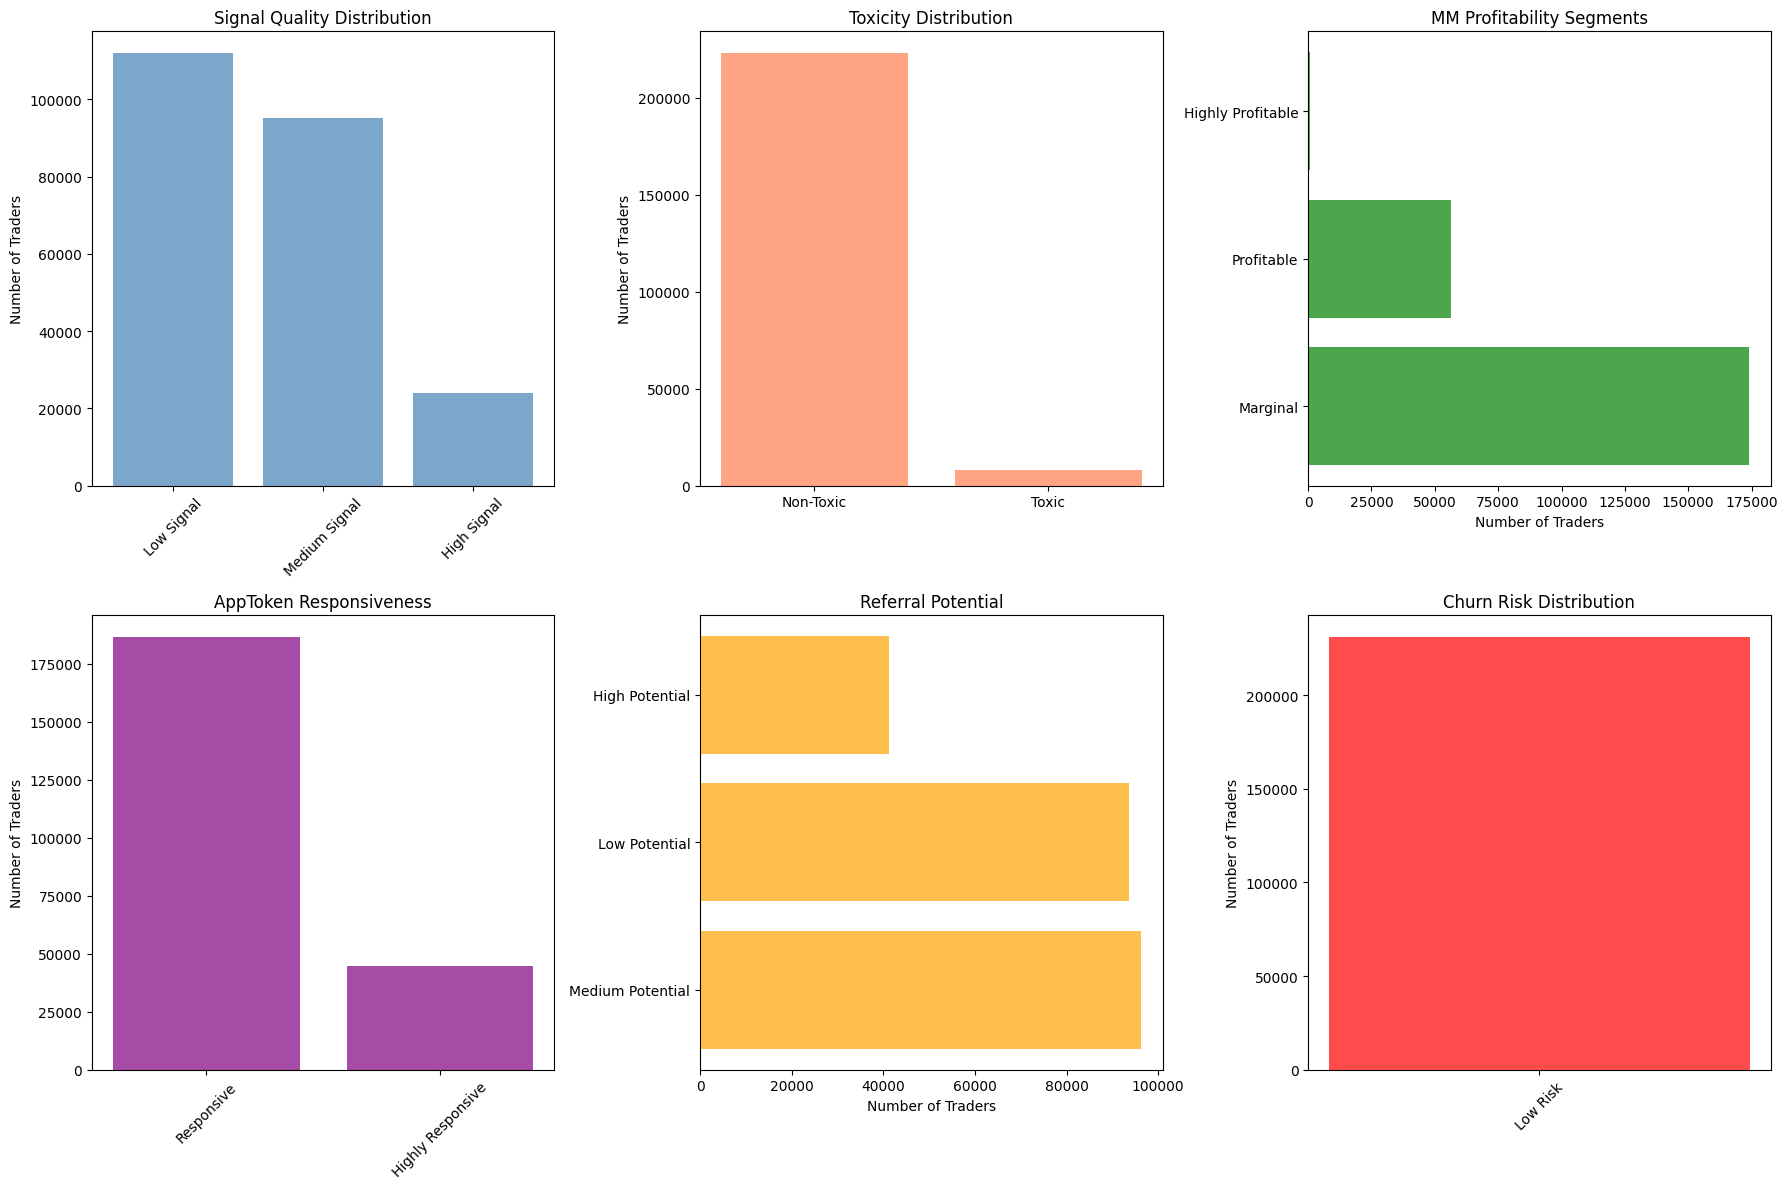


=== Ideal UA Targets (High Signal + Non-Toxic + MM Profitable) ===
Count: 14,789 traders
Total volume: $318,058,198.24
Average volume per trader: $21,506.40
Average trades per day: 15.17
Average unique markets: 19.5


In [26]:
# Visualize UA Strategy Segments
print("=== UA Strategy Visualizations ===\n")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Signal Quality Distribution
ax1 = axes[0, 0]
signal_counts = trader_segments_ua.group_by('signal_quality_segment').agg(pl.len().alias('count')).sort('count', descending=True)
ax1.bar(signal_counts['signal_quality_segment'].to_list(), signal_counts['count'].to_list(), color='steelblue', alpha=0.7)
ax1.set_title('Signal Quality Distribution')
ax1.set_ylabel('Number of Traders')
ax1.tick_params(axis='x', rotation=45)

# 2. Toxicity Distribution
ax2 = axes[0, 1]
toxicity_counts = trader_segments_ua.group_by('toxicity_segment').agg(pl.len().alias('count')).sort('count', descending=True)
ax2.bar(toxicity_counts['toxicity_segment'].to_list(), toxicity_counts['count'].to_list(), color='coral', alpha=0.7)
ax2.set_title('Toxicity Distribution')
ax2.set_ylabel('Number of Traders')

# 3. MM Profitability
ax3 = axes[0, 2]
mm_counts = trader_segments_ua.group_by('mm_profitability_segment').agg(pl.len().alias('count')).sort('count', descending=True)
ax3.barh(mm_counts['mm_profitability_segment'].to_list(), mm_counts['count'].to_list(), color='green', alpha=0.7)
ax3.set_title('MM Profitability Segments')
ax3.set_xlabel('Number of Traders')

# 4. AppToken Responsiveness
ax4 = axes[1, 0]
apptoken_counts = trader_segments_ua.group_by('apptoken_responsiveness_segment').agg(pl.len().alias('count')).sort('count', descending=True)
ax4.bar(apptoken_counts['apptoken_responsiveness_segment'].to_list(), apptoken_counts['count'].to_list(), color='purple', alpha=0.7)
ax4.set_title('AppToken Responsiveness')
ax4.set_ylabel('Number of Traders')
ax4.tick_params(axis='x', rotation=45)

# 5. Referral Potential
ax5 = axes[1, 1]
referral_counts = trader_segments_ua.group_by('referral_potential_segment').agg(pl.len().alias('count')).sort('count', descending=True)
ax5.barh(referral_counts['referral_potential_segment'].to_list(), referral_counts['count'].to_list(), color='orange', alpha=0.7)
ax5.set_title('Referral Potential')
ax5.set_xlabel('Number of Traders')

# 6. Churn Risk
ax6 = axes[1, 2]
churn_counts = trader_segments_ua.group_by('churn_risk_segment').agg(pl.len().alias('count')).sort('count', descending=True)
ax6.bar(churn_counts['churn_risk_segment'].to_list(), churn_counts['count'].to_list(), color='red', alpha=0.7)
ax6.set_title('Churn Risk Distribution')
ax6.set_ylabel('Number of Traders')
ax6.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Cross-segment analysis: High Signal + Non-Toxic + MM Profitable
print("\n=== Ideal UA Targets (High Signal + Non-Toxic + MM Profitable) ===")
ideal_targets = trader_segments_ua.filter(
    (pl.col('signal_quality_segment') == 'High Signal') &
    (pl.col('toxicity_segment') == 'Non-Toxic') &
    (pl.col('mm_profitability_segment').is_in(['Highly Profitable', 'Profitable']))
)
print(f"Count: {len(ideal_targets):,} traders")
print(f"Total volume: ${ideal_targets['total_volume'].sum():,.2f}")
print(f"Average volume per trader: ${ideal_targets['total_volume'].mean():,.2f}")
print(f"Average trades per day: {ideal_targets['trades_per_day'].mean():.2f}")
print(f"Average unique markets: {ideal_targets['unique_markets'].mean():.1f}")


In [27]:
# Export segmentation results
print("=== Segmentation Summary ===")
print(f"\nTotal traders analyzed: {len(trader_segments):,}")

print("\n=== Top Segments by Count ===")
top_segments = trader_segments.group_by('behavioral_profile').agg([
    pl.len().alias('count'),
    pl.col('total_volume').sum().alias('total_volume'),
]).sort('count', descending=True).head(10)

display_top = top_segments.with_columns([
    pl.col('total_volume').map_elements(lambda x: format_usd(x), return_dtype=pl.Utf8).alias('total_volume_usd'),
])
print(display_top)

print("\n=== Segment Characteristics ===")
segment_stats = trader_segments.group_by('volume_segment').agg([
    pl.len().alias('count'),
    pl.col('total_volume').sum().alias('total_volume'),
    pl.col('num_trades').mean().alias('avg_trades'),
    pl.col('unique_markets').mean().alias('avg_markets'),
    pl.col('buy_ratio').mean().alias('avg_buy_ratio'),
    pl.col('trades_per_day').mean().alias('avg_trades_per_day'),
]).sort('total_volume', descending=True)

display_stats = segment_stats.with_columns([
    pl.col('total_volume').map_elements(lambda x: format_usd(x), return_dtype=pl.Utf8).alias('total_volume_usd'),
])
print(display_stats)

# Export function
def export_segmentation(trader_segments: pl.DataFrame, output_path: str = 'trader_segments.csv'):
    """Export segmentation results to CSV."""
    output_file = PROJECT_ROOT / output_path
    trader_segments.write_csv(output_file)
    print(f"\n✓ Exported {len(trader_segments):,} trader segments to {output_file}")

# Uncomment to export
# export_segmentation(trader_segments, 'trader_segments.csv')


=== Segmentation Summary ===

Total traders analyzed: 231,034

=== Top Segments by Count ===
shape: (10, 4)
┌──────────────────────────────┬────────┬──────────────┬──────────────────┐
│ behavioral_profile           ┆ count  ┆ total_volume ┆ total_volume_usd │
│ ---                          ┆ ---    ┆ ---          ┆ ---              │
│ str                          ┆ u32    ┆ f64          ┆ str              │
╞══════════════════════════════╪════════╪══════════════╪══════════════════╡
│ Small - Casual - Focused     ┆ 208557 ┆ 9.0002e7     ┆ $90.00M          │
│ Small - Casual - Mixed       ┆ 4939   ┆ 7.3462e6     ┆ $7.35M           │
│ Small - Active - Mixed       ┆ 4188   ┆ 9.8773e6     ┆ $9.88M           │
│ Small - Active - Focused     ┆ 3736   ┆ 6.0534e6     ┆ $6.05M           │
│ Active - Casual - Focused    ┆ 3337   ┆ 6.8746e7     ┆ $68.75M          │
│ Active - Active - Mixed      ┆ 1565   ┆ 4.7638e7     ┆ $47.64M          │
│ Active - Active - Focused    ┆ 1062   ┆ 3.1226e7     ┆

In [28]:
# ============================================================================
# PHASE 0-1 TARGET PERSONA ANALYSIS
# Deep dive into the 3,539 high-signal, non-toxic, active traders
# ============================================================================

print("=" * 80)
print("PHASE 0-1 TARGET PERSONA ANALYSIS")
print("=" * 80)
print(f"\nTotal Targets: {len(phase_0_1_targets):,} traders")
print(f"Total Volume: ${phase_0_1_targets['total_volume'].sum():,.2f}")
print(f"Average Volume per Trader: ${phase_0_1_targets['total_volume'].mean():,.2f}")
print(f"Median Volume per Trader: ${phase_0_1_targets['total_volume'].median():,.2f}")
print()

# Create persona segments based on volume, frequency, and diversity
personas = phase_0_1_targets.with_columns([
    # Volume tiers
    pl.when(pl.col('total_volume') >= 500000).then(pl.lit('Whale'))
    .when(pl.col('total_volume') >= 100000).then(pl.lit('High Value'))
    .when(pl.col('total_volume') >= 50000).then(pl.lit('Mid Value'))
    .otherwise(pl.lit('Standard'))
    .alias('volume_tier'),
    
    # Trading frequency tiers
    pl.when(pl.col('trades_per_day') >= 20).then(pl.lit('Hyper Active'))
    .when(pl.col('trades_per_day') >= 10).then(pl.lit('Very Active'))
    .when(pl.col('trades_per_day') >= 5).then(pl.lit('Active'))
    .otherwise(pl.lit('Moderate'))
    .alias('frequency_tier'),
    
    # Market diversity tiers
    pl.when(pl.col('unique_markets') >= 30).then(pl.lit('Highly Diversified'))
    .when(pl.col('unique_markets') >= 15).then(pl.lit('Diversified'))
    .when(pl.col('unique_markets') >= 5).then(pl.lit('Moderate Diversity'))
    .otherwise(pl.lit('Focused'))
    .alias('diversity_tier'),
    
    # Trading style (buy vs sell ratio)
    pl.when(pl.col('buy_ratio') >= 0.7).then(pl.lit('Bullish'))
    .when(pl.col('buy_ratio') <= 0.3).then(pl.lit('Bearish'))
    .otherwise(pl.lit('Balanced'))
    .alias('trading_style'),
    
    # Trade size consistency
    pl.when(pl.col('trade_size_std') / pl.when(pl.col('avg_trade_size') > 0).then(pl.col('avg_trade_size')).otherwise(1) < 0.5).then(pl.lit('Consistent'))
    .when(pl.col('trade_size_std') / pl.when(pl.col('avg_trade_size') > 0).then(pl.col('avg_trade_size')).otherwise(1) < 1.0).then(pl.lit('Moderate Variance'))
    .otherwise(pl.lit('Variable'))
    .alias('size_consistency'),
    
    # Recency (days since last trade)
    pl.when(pl.col('days_since_last_trade') <= 1).then(pl.lit('Very Recent'))
    .when(pl.col('days_since_last_trade') <= 3).then(pl.lit('Recent'))
    .otherwise(pl.lit('Active'))
    .alias('recency_tier'),
])

# Calculate composite persona
personas = personas.with_columns([
    pl.concat_str([
        pl.col('volume_tier'),
        pl.lit(' - '),
        pl.col('frequency_tier'),
        pl.lit(' - '),
        pl.col('diversity_tier')
    ], separator='').alias('composite_persona')
])

print("=" * 80)
print("1. VOLUME TIER BREAKDOWN")
print("=" * 80)
volume_breakdown = personas.group_by('volume_tier').agg([
    pl.len().alias('count'),
    pl.col('total_volume').sum().alias('total_volume'),
    pl.col('total_volume').mean().alias('avg_volume'),
    pl.col('total_volume').median().alias('median_volume'),
    pl.col('num_trades').mean().alias('avg_trades'),
    pl.col('trades_per_day').mean().alias('avg_trades_per_day'),
    pl.col('unique_markets').mean().alias('avg_markets'),
]).sort('total_volume', descending=True)

display_vol = volume_breakdown.with_columns([
    pl.col('total_volume').map_elements(lambda x: format_usd(x), return_dtype=pl.Utf8).alias('total_volume_usd'),
    pl.col('avg_volume').map_elements(lambda x: format_usd(x), return_dtype=pl.Utf8).alias('avg_volume_usd'),
    pl.col('median_volume').map_elements(lambda x: format_usd(x), return_dtype=pl.Utf8).alias('median_volume_usd'),
])
print(display_vol)
print()

print("=" * 80)
print("2. TRADING FREQUENCY BREAKDOWN")
print("=" * 80)
freq_breakdown = personas.group_by('frequency_tier').agg([
    pl.len().alias('count'),
    pl.col('total_volume').sum().alias('total_volume'),
    pl.col('trades_per_day').mean().alias('avg_trades_per_day'),
    pl.col('trades_per_day').median().alias('median_trades_per_day'),
    pl.col('num_trades').mean().alias('avg_total_trades'),
    pl.col('unique_markets').mean().alias('avg_markets'),
]).sort('avg_trades_per_day', descending=True)

display_freq = freq_breakdown.with_columns([
    pl.col('total_volume').map_elements(lambda x: format_usd(x), return_dtype=pl.Utf8).alias('total_volume_usd'),
])
print(display_freq)
print()

print("=" * 80)
print("3. MARKET DIVERSITY BREAKDOWN")
print("=" * 80)
div_breakdown = personas.group_by('diversity_tier').agg([
    pl.len().alias('count'),
    pl.col('total_volume').sum().alias('total_volume'),
    pl.col('unique_markets').mean().alias('avg_markets'),
    pl.col('unique_markets').median().alias('median_markets'),
    pl.col('trades_per_market').mean().alias('avg_trades_per_market'),
    pl.col('trades_per_day').mean().alias('avg_trades_per_day'),
]).sort('avg_markets', descending=True)

display_div = div_breakdown.with_columns([
    pl.col('total_volume').map_elements(lambda x: format_usd(x), return_dtype=pl.Utf8).alias('total_volume_usd'),
])
print(display_div)
print()

print("=" * 80)
print("4. TRADING STYLE BREAKDOWN")
print("=" * 80)
style_breakdown = personas.group_by('trading_style').agg([
    pl.len().alias('count'),
    pl.col('total_volume').sum().alias('total_volume'),
    pl.col('buy_ratio').mean().alias('avg_buy_ratio'),
    pl.col('buy_volume_ratio').mean().alias('avg_buy_volume_ratio'),
    pl.col('avg_trade_size').mean().alias('avg_trade_size'),
    pl.col('trades_per_day').mean().alias('avg_trades_per_day'),
]).sort('count', descending=True)

display_style = style_breakdown.with_columns([
    pl.col('total_volume').map_elements(lambda x: format_usd(x), return_dtype=pl.Utf8).alias('total_volume_usd'),
    pl.col('avg_trade_size').map_elements(lambda x: format_usd(x), return_dtype=pl.Utf8).alias('avg_trade_size_usd'),
])
print(display_style)
print()

print("=" * 80)
print("5. KEY PERSONAS (Top 10 Composite Segments)")
print("=" * 80)
top_personas = personas.group_by('composite_persona').agg([
    pl.len().alias('count'),
    pl.col('total_volume').sum().alias('total_volume'),
    pl.col('total_volume').mean().alias('avg_volume'),
    pl.col('trades_per_day').mean().alias('avg_trades_per_day'),
    pl.col('unique_markets').mean().alias('avg_markets'),
    pl.col('buy_ratio').mean().alias('avg_buy_ratio'),
    pl.col('days_since_last_trade').mean().alias('avg_days_since_last'),
    pl.col('signal_quality_score').mean().alias('avg_signal_score'),
    pl.col('mm_profitability_score').mean().alias('avg_mm_score'),
]).sort('total_volume', descending=True).head(10)

display_personas = top_personas.with_columns([
    pl.col('total_volume').map_elements(lambda x: format_usd(x), return_dtype=pl.Utf8).alias('total_volume_usd'),
    pl.col('avg_volume').map_elements(lambda x: format_usd(x), return_dtype=pl.Utf8).alias('avg_volume_usd'),
])
print(display_personas)
print()

print("=" * 80)
print("6. TRADING BEHAVIOR INSIGHTS")
print("=" * 80)
print(f"\n📊 Volume Distribution:")
print(f"   - Top 10%: ${phase_0_1_targets['total_volume'].quantile(0.9):,.2f} avg")
print(f"   - Top 25%: ${phase_0_1_targets['total_volume'].quantile(0.75):,.2f} avg")
print(f"   - Median: ${phase_0_1_targets['total_volume'].median():,.2f}")
print(f"   - Bottom 25%: ${phase_0_1_targets['total_volume'].quantile(0.25):,.2f} avg")

print(f"\n⚡ Activity Metrics:")
print(f"   - Avg trades per day: {phase_0_1_targets['trades_per_day'].mean():.2f}")
print(f"   - Median trades per day: {phase_0_1_targets['trades_per_day'].median():.2f}")
print(f"   - Avg total trades: {phase_0_1_targets['num_trades'].mean():.0f}")
print(f"   - Avg days active: {phase_0_1_targets['days_since_first_trade'].mean():.1f}")

print(f"\n🎯 Market Engagement:")
print(f"   - Avg unique markets: {phase_0_1_targets['unique_markets'].mean():.1f}")
print(f"   - Median unique markets: {phase_0_1_targets['unique_markets'].median():.0f}")
print(f"   - Avg trades per market: {phase_0_1_targets['trades_per_market'].mean():.2f}")

print(f"\n💰 Trade Size Patterns:")
print(f"   - Avg trade size: ${phase_0_1_targets['avg_trade_size'].mean():,.2f}")
print(f"   - Median trade size: ${phase_0_1_targets['median_trade_size'].mean():,.2f}")
print(f"   - Max trade size: ${phase_0_1_targets['max_trade_size'].mean():,.2f}")

print(f"\n📈 Trading Direction:")
print(f"   - Avg buy ratio: {phase_0_1_targets['buy_ratio'].mean():.2%}")
print(f"   - Balanced traders (40-60% buy): {len(personas.filter((pl.col('buy_ratio') >= 0.4) & (pl.col('buy_ratio') <= 0.6))):,} ({len(personas.filter((pl.col('buy_ratio') >= 0.4) & (pl.col('buy_ratio') <= 0.6))) / len(personas) * 100:.1f}%)")

print(f"\n⏰ Recency:")
print(f"   - Avg days since last trade: {phase_0_1_targets['days_since_last_trade'].mean():.2f}")
print(f"   - Traded in last 24h: {len(personas.filter(pl.col('days_since_last_trade') <= 1)):,} ({len(personas.filter(pl.col('days_since_last_trade') <= 1)) / len(personas) * 100:.1f}%)")
print(f"   - Traded in last 3 days: {len(personas.filter(pl.col('days_since_last_trade') <= 3)):,} ({len(personas.filter(pl.col('days_since_last_trade') <= 3)) / len(personas) * 100:.1f}%)")

print(f"\n🎯 Quality Scores:")
print(f"   - Avg signal quality: {phase_0_1_targets['signal_quality_score'].mean():.1f}/100")
print(f"   - Avg MM profitability: {phase_0_1_targets['mm_profitability_score'].mean():.1f}/100")
print(f"   - Avg AppToken responsiveness: {phase_0_1_targets['apptoken_responsiveness_score'].mean():.1f}/100")
print()

print("=" * 80)
print("7. ACTIONABLE PERSONAS FOR GTM STRATEGY")
print("=" * 80)

# Define key personas
whale_hyper = personas.filter(
    (pl.col('volume_tier') == 'Whale') & 
    (pl.col('frequency_tier') == 'Hyper Active')
)
whale_active = personas.filter(
    (pl.col('volume_tier') == 'Whale') & 
    (pl.col('frequency_tier').is_in(['Very Active', 'Active']))
)
high_value_diversified = personas.filter(
    (pl.col('volume_tier').is_in(['Whale', 'High Value'])) &
    (pl.col('diversity_tier').is_in(['Highly Diversified', 'Diversified']))
)
balanced_traders = personas.filter(
    (pl.col('trading_style') == 'Balanced') &
    (pl.col('total_volume') >= 50000)
)
recent_high_volume = personas.filter(
    (pl.col('recency_tier') == 'Very Recent') &
    (pl.col('total_volume') >= 100000)
)

print(f"\n🔵 PERSONA 1: 'Market Makers / Liquidity Providers'")
print(f"   Count: {len(whale_hyper):,} traders")
print(f"   Total Volume: ${whale_hyper['total_volume'].sum():,.2f}")
print(f"   Avg Volume: ${whale_hyper['total_volume'].mean():,.2f}")
print(f"   Avg Trades/Day: {whale_hyper['trades_per_day'].mean():.1f}")
print(f"   Avg Markets: {whale_hyper['unique_markets'].mean():.1f}")
print(f"   Avg Buy Ratio: {whale_hyper['buy_ratio'].mean():.2%} (balanced)")
print(f"   Characteristics: Hyper-active, balanced buy/sell, highly diversified, consistent sizes")
print(f"   GTM Strategy: LP vault recruitment, MM partnerships, liquidity incentives")
print(f"   Value Prop: TVL opportunities, fee sharing, stable yield, reduced risk")
print(f"   Note: These are LIQUIDITY PROVIDERS - separate from taker acquisition")

print(f"\n👑 PERSONA 2: 'Elite Signal Takers'")
print(f"   Count: {len(whale_active):,} traders")
print(f"   Total Volume: ${whale_active['total_volume'].sum():,.2f}")
print(f"   Avg Volume: ${whale_active['total_volume'].mean():,.2f}")
print(f"   Avg Trades/Day: {whale_active['trades_per_day'].mean():.1f}")
print(f"   Avg Buy Ratio: {whale_active['buy_ratio'].mean():.2%}")
print(f"   Characteristics: High-signal, directional trading, profitable flow for MMs")
print(f"   GTM Strategy: VIP program, dedicated account manager, early access to new markets")
print(f"   Value Prop: Lowest fees, priority support, exclusive parlay opportunities")

print(f"\n🌐 PERSONA 3: 'Multi-Market Strategists'")
print(f"   Count: {len(high_value_diversified):,} traders")
print(f"   Total Volume: ${high_value_diversified['total_volume'].sum():,.2f}")
print(f"   Avg Volume: ${high_value_diversified['total_volume'].mean():,.2f}")
print(f"   Avg Markets: {high_value_diversified['unique_markets'].mean():.1f}")
print(f"   GTM Strategy: Cross-market parlay incentives, market discovery tools")
print(f"   Value Prop: Multi-market parlays, correlation insights, portfolio tools")

print(f"\n⚖️ PERSONA 4: 'Steady Flow Traders'")
print(f"   Count: {len(balanced_traders):,} traders")
print(f"   Total Volume: ${balanced_traders['total_volume'].sum():,.2f}")
print(f"   Avg Volume: ${balanced_traders['total_volume'].mean():,.2f}")
print(f"   Avg Buy Ratio: {balanced_traders['buy_ratio'].mean():.2%}")
print(f"   GTM Strategy: AppToken rewards for balanced trading, referral bonuses")
print(f"   Value Prop: Consistent rewards, community access, educational content")

print(f"\n🔥 PERSONA 5: 'Hot Hand Traders'")
print(f"   Count: {len(recent_high_volume):,} traders")
print(f"   Total Volume: ${recent_high_volume['total_volume'].sum():,.2f}")
print(f"   Avg Volume: ${recent_high_volume['total_volume'].mean():,.2f}")
print(f"   Days Since Last Trade: {recent_high_volume['days_since_last_trade'].mean():.1f}")
print(f"   GTM Strategy: Immediate onboarding, welcome bonuses, fast-track to VIP")
print(f"   Value Prop: Quick setup, instant liquidity, competitive rates")

print("\n" + "=" * 80)
print("8. TRADING PATTERN ANALYSIS")
print("=" * 80)

# Analyze trade patterns
print(f"\n📊 Trade Size Distribution:")
print(f"   - Consistent size traders: {len(personas.filter(pl.col('size_consistency') == 'Consistent')):,} ({len(personas.filter(pl.col('size_consistency') == 'Consistent')) / len(personas) * 100:.1f}%)")
print(f"   - Variable size traders: {len(personas.filter(pl.col('size_consistency') == 'Variable')):,} ({len(personas.filter(pl.col('size_consistency') == 'Variable')) / len(personas) * 100:.1f}%)")

print(f"\n🔄 Trading Frequency Patterns:")
freq_dist = personas.group_by('frequency_tier').agg([
    pl.len().alias('count'),
    pl.col('total_volume').sum().alias('total_volume'),
]).sort('count', descending=True)
for row in freq_dist.iter_rows(named=True):
    pct = row['count'] / len(personas) * 100
    vol_pct = row['total_volume'] / personas['total_volume'].sum() * 100
    print(f"   - {row['frequency_tier']}: {row['count']:,} ({pct:.1f}% of traders, {vol_pct:.1f}% of volume)")

print(f"\n🎯 Market Focus:")
div_dist = personas.group_by('diversity_tier').agg([
    pl.len().alias('count'),
    pl.col('total_volume').sum().alias('total_volume'),
]).sort('count', descending=True)
for row in div_dist.iter_rows(named=True):
    pct = row['count'] / len(personas) * 100
    vol_pct = row['total_volume'] / personas['total_volume'].sum() * 100
    print(f"   - {row['diversity_tier']}: {row['count']:,} ({pct:.1f}% of traders, {vol_pct:.1f}% of volume)")

print("\n" + "=" * 80)
print("9. KEY INSIGHTS & RECOMMENDATIONS")
print("=" * 80)

print("\n💡 INSIGHT 1: Volume Concentration")
top_10_pct = personas.sort('total_volume', descending=True).head(int(len(personas) * 0.1))
print(f"   - Top 10% of traders account for ${top_10_pct['total_volume'].sum():,.2f} ({top_10_pct['total_volume'].sum() / personas['total_volume'].sum() * 100:.1f}% of total volume)")
print(f"   - Recommendation: Focus VIP program on top 10% (354 traders) for maximum impact")

print("\n💡 INSIGHT 2: Activity vs Volume")
high_activity = personas.filter(pl.col('trades_per_day') >= 10)
print(f"   - {len(high_activity):,} traders ({len(high_activity) / len(personas) * 100:.1f}%) trade 10+ times per day")
print(f"   - They account for ${high_activity['total_volume'].sum():,.2f} ({high_activity['total_volume'].sum() / personas['total_volume'].sum() * 100:.1f}% of volume)")
print(f"   - Recommendation: AppToken rewards should scale with frequency, not just volume")

print("\n💡 INSIGHT 3: Market Diversity Opportunity")
focused_traders = personas.filter(pl.col('diversity_tier') == 'Focused')
print(f"   - {len(focused_traders):,} traders ({len(focused_traders) / len(personas) * 100:.1f}%) trade in <5 markets")
print(f"   - Recommendation: Incentivize cross-market parlays to increase diversity and stickiness")

print("\n💡 INSIGHT 4: Balanced Trading is Key")
balanced = personas.filter((pl.col('buy_ratio') >= 0.4) & (pl.col('buy_ratio') <= 0.6))
print(f"   - {len(balanced):,} traders ({len(balanced) / len(personas) * 100:.1f}%) have balanced buy/sell ratios")
print(f"   - These traders are ideal for MM profitability")
print(f"   - Recommendation: Reward balanced trading patterns with better rates")

print("\n💡 INSIGHT 5: Recency = Engagement")
very_recent = personas.filter(pl.col('days_since_last_trade') <= 1)
print(f"   - {len(very_recent):,} traders ({len(very_recent) / len(personas) * 100:.1f}%) traded in last 24h")
print(f"   - Recommendation: Push notifications and real-time incentives for active traders")

print("\n" + "=" * 80)
print("10. PRIORITIZED ACQUISITION STRATEGY")
print("=" * 80)

print("\n🎯 TIER 1: Immediate Priority (Top 100 by Volume)")
tier1 = personas.sort('total_volume', descending=True).head(100)
print(f"   - Count: 100 traders")
print(f"   - Total Volume: ${tier1['total_volume'].sum():,.2f}")
print(f"   - Avg Volume: ${tier1['total_volume'].mean():,.2f}")
print(f"   - Strategy: 1:1 outreach, custom deals, white-glove onboarding")
print(f"   - Expected Conversion: 30-40% (30-40 traders)")

print("\n🎯 TIER 2: High Priority (Next 400 by Volume)")
tier2 = personas.sort('total_volume', descending=True).slice(100, 400)
print(f"   - Count: 300 traders")
print(f"   - Total Volume: ${tier2['total_volume'].sum():,.2f}")
print(f"   - Avg Volume: ${tier2['total_volume'].mean():,.2f}")
print(f"   - Strategy: Personalized email campaigns, tiered incentives, community access")
print(f"   - Expected Conversion: 20-30% (60-90 traders)")

print("\n🎯 TIER 3: Standard Priority (Remaining 3,139)")
tier3 = personas.sort('total_volume', descending=True).slice(400)
print(f"   - Count: {len(tier3):,} traders")
print(f"   - Total Volume: ${tier3['total_volume'].sum():,.2f}")
print(f"   - Strategy: Automated onboarding, AppToken rewards, referral program")
print(f"   - Expected Conversion: 10-15% ({int(len(tier3) * 0.1):,}-{int(len(tier3) * 0.15):,} traders)")

print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"\n✅ Total Addressable Market: {len(phase_0_1_targets):,} traders")
print(f"✅ Total Volume Opportunity: ${phase_0_1_targets['total_volume'].sum():,.2f}")
print(f"✅ Average LTV per Trader: ${phase_0_1_targets['total_volume'].mean():,.2f}")
print(f"✅ Top 10% Concentration: {top_10_pct['total_volume'].sum() / personas['total_volume'].sum() * 100:.1f}% of volume")
print(f"\n🎯 Focus Areas:")
print(f"   1. Market Makers (LP Acquisition): {len(whale_hyper):,} traders, ${whale_hyper['total_volume'].sum():,.2f} volume")
print(f"   2. Elite Signal Takers: {len(whale_active):,} traders, ${whale_active['total_volume'].sum():,.2f} volume")
print(f"   3. Multi-Market Strategists: {len(high_value_diversified):,} traders, ${high_value_diversified['total_volume'].sum():,.2f} volume")
print(f"   4. Hot Hand Traders: {len(recent_high_volume):,} traders, ${recent_high_volume['total_volume'].sum():,.2f} volume")
print("\n" + "=" * 80)


PHASE 0-1 TARGET PERSONA ANALYSIS

Total Targets: 3,404 traders
Total Volume: $316,783,847.34
Average Volume per Trader: $93,062.23
Median Volume per Trader: $23,460.69

1. VOLUME TIER BREAKDOWN
shape: (4, 11)
┌─────────────┬───────┬──────────────┬───────────────┬───────────────┬─────────────┬────────────────────┬─────────────┬──────────────────┬────────────────┬───────────────────┐
│ volume_tier ┆ count ┆ total_volume ┆ avg_volume    ┆ median_volume ┆ avg_trades  ┆ avg_trades_per_day ┆ avg_markets ┆ total_volume_usd ┆ avg_volume_usd ┆ median_volume_usd │
│ ---         ┆ ---   ┆ ---          ┆ ---           ┆ ---           ┆ ---         ┆ ---                ┆ ---         ┆ ---              ┆ ---            ┆ ---               │
│ str         ┆ u32   ┆ f64          ┆ f64           ┆ f64           ┆ f64         ┆ f64                ┆ f64         ┆ str              ┆ str            ┆ str               │
╞═════════════╪═══════╪══════════════╪═══════════════╪═══════════════╪═════════════╪══

In [29]:
# ============================================================================
# MARKET TYPE ANALYSIS & ACQUISITION CHANNEL ANALYSIS
# ============================================================================

print("=" * 80)
print("MARKET TYPE & ACQUISITION CHANNEL ANALYSIS")
print("=" * 80)

# Join Phase 0-1 targets with their market activity
phase_0_1_markets = (
    trades
    .filter(pl.col('maker').is_in(phase_0_1_targets['maker'].to_list()))
    .group_by(['maker', 'market_id'])
    .agg([
        pl.col('usd_amount').sum().alias('market_volume'),
        pl.len().alias('market_trades'),
        pl.col('maker_direction').eq('BUY').mean().alias('buy_ratio'),
    ])
    .join(
        markets_df.select(['id', 'question', 'ticker', 'volume', 'createdAt', 'closedTime']).rename({'id': 'market_id'}),
        on='market_id',
        how='left'
    )
)

# Categorize markets by ticker/type using Polars-native operations
def categorize_market_text(text: str) -> str:
    """Categorize market based on combined question and ticker text."""
    if not text or text is None:
        return 'Other'
    
    text_lower = str(text).lower()
    
    # Politics
    if any(word in text_lower for word in ['president', 'election', 'trump', 'biden', 'senate', 'congress', 'vote', 'poll', 'primary']):
        return 'Politics'
    # Sports
    elif any(word in text_lower for word in ['nfl', 'nba', 'mlb', 'soccer', 'football', 'basketball', 'baseball', 'championship', 'super bowl', 'world cup']):
        return 'Sports'
    # Crypto
    elif any(word in text_lower for word in ['bitcoin', 'btc', 'ethereum', 'eth', 'crypto', 'token', 'coin', 'defi', 'nft']):
        return 'Crypto'
    # Economics
    elif any(word in text_lower for word in ['inflation', 'gdp', 'fed', 'interest rate', 'unemployment', 'recession', 'stock', 's&p', 'dow']):
        return 'Economics'
    # Entertainment
    elif any(word in text_lower for word in ['oscar', 'grammy', 'movie', 'tv show', 'celebrity', 'award', 'box office']):
        return 'Entertainment'
    # Technology
    elif any(word in text_lower for word in ['ai', 'artificial intelligence', 'tech', 'apple', 'google', 'meta', 'microsoft', 'product launch']):
        return 'Technology'
    # Weather/Disasters
    elif any(word in text_lower for word in ['hurricane', 'earthquake', 'flood', 'weather', 'temperature', 'climate']):
        return 'Weather/Disasters'
    # Health
    elif any(word in text_lower for word in ['covid', 'pandemic', 'disease', 'health', 'medical', 'drug', 'fda']):
        return 'Health'
    else:
        return 'Other'

# Apply categorization using Polars map_elements
phase_0_1_markets_cat = phase_0_1_markets.with_columns([
    pl.concat_str([
        pl.col('question').fill_null(''),
        pl.lit(' '),
        pl.col('ticker').fill_null('')
    ]).alias('_combined_text')
]).with_columns([
    pl.col('_combined_text').map_elements(
        categorize_market_text,
        return_dtype=pl.Utf8
    ).alias('market_category')
]).drop('_combined_text')

print("\n" + "=" * 80)
print("1. MARKET TYPE PREFERENCES (Phase 0-1 Targets)")
print("=" * 80)

market_category_analysis = phase_0_1_markets_cat.group_by('market_category').agg([
    pl.len().alias('unique_trader_market_pairs'),
    pl.col('market_volume').sum().alias('total_volume'),
    pl.col('market_trades').sum().alias('total_trades'),
    pl.col('market_id').n_unique().alias('unique_markets'),
    pl.col('maker').n_unique().alias('unique_traders'),
]).sort('total_volume', descending=True)

display_market_cat = market_category_analysis.with_columns([
    pl.col('total_volume').map_elements(lambda x: format_usd(x), return_dtype=pl.Utf8).alias('total_volume_usd'),
])
print(display_market_cat)

# Calculate trader concentration by category
print("\n" + "=" * 80)
print("2. TRADER CONCENTRATION BY MARKET TYPE")
print("=" * 80)

trader_category_preference = (
    phase_0_1_markets_cat
    .group_by(['maker', 'market_category'])
    .agg(pl.col('market_volume').sum().alias('category_volume'))
    .group_by('market_category')
    .agg([
        pl.len().alias('traders_active'),
        pl.col('category_volume').sum().alias('total_volume'),
    ])
    .sort('traders_active', descending=True)
)

display_trader_cat = trader_category_preference.with_columns([
    pl.col('total_volume').map_elements(lambda x: format_usd(x), return_dtype=pl.Utf8).alias('total_volume_usd'),
    (pl.col('traders_active') / len(phase_0_1_targets) * 100).alias('pct_of_targets'),
])
print(display_trader_cat)

print("\n" + "=" * 80)
print("3. TOP MARKETS BY VOLUME (Phase 0-1 Targets)")
print("=" * 80)

top_markets = (
    phase_0_1_markets_cat
    .group_by(['market_id', 'question', 'market_category'])
    .agg([
        pl.col('market_volume').sum().alias('total_volume'),
        pl.col('market_trades').sum().alias('total_trades'),
        pl.col('maker').n_unique().alias('unique_traders'),
    ])
    .sort('total_volume', descending=True)
    .head(20)
)

display_top_markets = top_markets.with_columns([
    pl.col('total_volume').map_elements(lambda x: format_usd(x), return_dtype=pl.Utf8).alias('total_volume_usd'),
])
print(display_top_markets.select(['question', 'market_category', 'total_volume_usd', 'total_trades', 'unique_traders']))


MARKET TYPE & ACQUISITION CHANNEL ANALYSIS

1. MARKET TYPE PREFERENCES (Phase 0-1 Targets)
shape: (9, 7)
┌───────────────────┬────────────────────────────┬──────────────┬──────────────┬────────────────┬────────────────┬──────────────────┐
│ market_category   ┆ unique_trader_market_pairs ┆ total_volume ┆ total_trades ┆ unique_markets ┆ unique_traders ┆ total_volume_usd │
│ ---               ┆ ---                        ┆ ---          ┆ ---          ┆ ---            ┆ ---            ┆ ---              │
│ str               ┆ u32                        ┆ f64          ┆ u32          ┆ u32            ┆ u32            ┆ str              │
╞═══════════════════╪════════════════════════════╪══════════════╪══════════════╪════════════════╪════════════════╪══════════════════╡
│ Other             ┆ 45091                      ┆ 1.1473e8     ┆ 315924       ┆ 5425           ┆ 2779           ┆ $114.73M         │
│ Sports            ┆ 20176                      ┆ 7.7890e7     ┆ 170197       ┆ 1576      

In [30]:
# ============================================================================
# EXCLUDED/DEPRIORITIZED PERSONAS ANALYSIS
# ============================================================================

print("=" * 80)
print("EXCLUDED & DEPRIORITIZED PERSONAS")
print("=" * 80)

# Get all traders for comparison
all_traders = trader_segments_ua

# 1. TOXIC TRADERS (Excluded)
toxic_traders_excluded = all_traders.filter(pl.col('toxicity_segment') == 'Toxic')
print(f"\n🚫 EXCLUDED: Toxic Traders")
print(f"   Count: {len(toxic_traders_excluded):,} traders")
print(f"   Total Volume: ${toxic_traders_excluded['total_volume'].sum():,.2f}")
print(f"   Breakdown:")
print(f"     - Bonus hunters: {toxic_traders_excluded['potential_bonus_hunter'].sum():,}")
print(f"     - Arbitrageurs: {toxic_traders_excluded['potential_arbitrageur'].sum():,}")
print(f"     - Toxic flow: {toxic_traders_excluded['potential_toxic_flow'].sum():,}")
print(f"   Reason: Generate unprofitable flow for MMs, exploit incentives")

# 2. LOW SIGNAL TRADERS (Deprioritized)
low_signal = all_traders.filter(
    (pl.col('signal_quality_segment') == 'Low Signal') &
    (pl.col('toxicity_segment') == 'Non-Toxic')
)
print(f"\n⚠️ DEPRIORITIZED: Low Signal Traders")
print(f"   Count: {len(low_signal):,} traders")
print(f"   Total Volume: ${low_signal['total_volume'].sum():,.2f}")
print(f"   Avg Signal Score: {(low_signal['signal_quality_score'].mean() or 0):.1f}/100")
print(f"   Characteristics:")
print(f"     - Avg trades/day: {(low_signal['trades_per_day'].mean() or 0):.2f}")
print(f"     - Avg markets: {(low_signal['unique_markets'].mean() or 0):.1f}")
print(f"     - Avg volume: ${(low_signal['total_volume'].mean() or 0):,.2f}")
print(f"   Reason: Erratic patterns, low diversity, extreme buy/sell ratios")

# 3. INACTIVE TRADERS (Deprioritized)
inactive = all_traders.filter(
    (pl.col('days_since_last_trade') > 30) &
    (pl.col('toxicity_segment') == 'Non-Toxic')
)
print(f"\n⏸️ DEPRIORITIZED: Inactive Traders (>30 days)")
print(f"   Count: {len(inactive):,} traders")
print(f"   Total Volume: ${inactive['total_volume'].sum():,.2f}")
print(f"   Avg days since last trade: {(inactive['days_since_last_trade'].mean() or 0):.1f}")
print(f"   Reason: Low engagement, high churn risk")

# 4. LOW VOLUME TRADERS (Deprioritized for Phase 0-1)
low_volume = all_traders.filter(
    (pl.col('total_volume') < 10000) &
    (pl.col('toxicity_segment') == 'Non-Toxic') &
    (pl.col('signal_quality_segment').is_in(['High Signal', 'Medium Signal']))
)
print(f"\n📉 DEPRIORITIZED: Low Volume High-Signal Traders (<$10K)")
print(f"   Count: {len(low_volume):,} traders")
print(f"   Total Volume: ${low_volume['total_volume'].sum():,.2f}")
print(f"   Avg Volume: ${(low_volume['total_volume'].mean() or 0):,.2f}")
print(f"   Reason: Good signal but insufficient volume for Phase 0-1 bootstrap")

# 5. MARGINAL MM PROFITABILITY (Deprioritized)
marginal_mm = all_traders.filter(
    (pl.col('mm_profitability_segment') == 'Marginal') &
    (pl.col('toxicity_segment') == 'Non-Toxic') &
    (pl.col('signal_quality_segment') == 'High Signal')
)
print(f"\n📊 DEPRIORITIZED: High Signal but Marginal MM Profitability")
print(f"   Count: {len(marginal_mm):,} traders")
print(f"   Total Volume: ${marginal_mm['total_volume'].sum():,.2f}")
print(f"   Avg MM Score: {(marginal_mm['mm_profitability_score'].mean() or 0):.1f}/100")
print(f"   Reason: May not generate profitable flow for MMs despite high signal")

# 6. LOW APPToken RESPONSIVENESS (Deprioritized)
low_apptoken = all_traders.filter(
    (pl.col('apptoken_responsiveness_segment') == 'Low Responsiveness') &
    (pl.col('toxicity_segment') == 'Non-Toxic') &
    (pl.col('signal_quality_segment') == 'High Signal')
)
print(f"\n🎁 DEPRIORITIZED: Low AppToken Responsiveness")
print(f"   Count: {len(low_apptoken):,} traders")
print(f"   Total Volume: ${low_apptoken['total_volume'].sum():,.2f}")
print(f"   Avg Responsiveness Score: {(low_apptoken['apptoken_responsiveness_score'].mean() or 0):.1f}/100")
print(f"   Reason: Unlikely to respond to incentive programs")

print("\n" + "=" * 80)
print("EXCLUSION SUMMARY")
print("=" * 80)
print(f"\n✅ Phase 0-1 Targets: {len(phase_0_1_targets):,} traders (${phase_0_1_targets['total_volume'].sum():,.2f})")
print(f"🚫 Excluded (Toxic): {len(toxic_traders_excluded):,} traders (${toxic_traders_excluded['total_volume'].sum():,.2f})")
print(f"⚠️ Deprioritized (Low Signal): {len(low_signal):,} traders (${low_signal['total_volume'].sum():,.2f})")
print(f"⏸️ Deprioritized (Inactive): {len(inactive):,} traders (${inactive['total_volume'].sum():,.2f})")
print(f"📉 Deprioritized (Low Volume): {len(low_volume):,} traders (${low_volume['total_volume'].sum():,.2f})")
print(f"📊 Deprioritized (Marginal MM): {len(marginal_mm):,} traders (${marginal_mm['total_volume'].sum():,.2f})")
print(f"🎁 Deprioritized (Low AppToken): {len(low_apptoken):,} traders (${low_apptoken['total_volume'].sum():,.2f})")


EXCLUDED & DEPRIORITIZED PERSONAS

🚫 EXCLUDED: Toxic Traders
   Count: 7,968 traders
   Total Volume: $181,067,200.41
   Breakdown:
     - Bonus hunters: 333
     - Arbitrageurs: 1,984
     - Toxic flow: 5,703
   Reason: Generate unprofitable flow for MMs, exploit incentives

⚠️ DEPRIORITIZED: Low Signal Traders
   Count: 107,748 traders
   Total Volume: $25,248,311.19
   Avg Signal Score: 27.0/100
   Characteristics:
     - Avg trades/day: 0.64
     - Avg markets: 1.9
     - Avg volume: $234.33
   Reason: Erratic patterns, low diversity, extreme buy/sell ratios

⏸️ DEPRIORITIZED: Inactive Traders (>30 days)
   Count: 0 traders
   Total Volume: $0.00
   Avg days since last trade: 0.0
   Reason: Low engagement, high churn risk

📉 DEPRIORITIZED: Low Volume High-Signal Traders (<$10K)
   Count: 108,798 traders
   Total Volume: $92,695,809.60
   Avg Volume: $852.00
   Reason: Good signal but insufficient volume for Phase 0-1 bootstrap

📊 DEPRIORITIZED: High Signal but Marginal MM Profitabi

In [31]:
# ============================================================================
# ELIGIBILITY & FILTERS
# ============================================================================

print("=" * 80)
print("ELIGIBILITY CRITERIA & FILTERS")
print("=" * 80)

print("\n" + "=" * 80)
print("PHASE 0-1 ELIGIBILITY CRITERIA")
print("=" * 80)

print("\n✅ REQUIRED CRITERIA:")
print("   1. Signal Quality: High Signal (score ≥ 70)")
print("   2. Toxicity: Non-Toxic (no bonus hunting, arbitrage, or toxic flow)")
print("   3. Volume: ≥ $10,000 total volume")
print("   4. Recency: Traded within last 7 days")
print("   5. Platform Wallets: Excluded (known platform/contract addresses)")

print("\n📊 CURRENT FILTER RESULTS:")
print(f"   - Total traders analyzed: {len(trader_segments_ua):,}")
print(f"   - High Signal traders: {len(trader_segments_ua.filter(pl.col('signal_quality_segment') == 'High Signal')):,}")
print(f"   - Non-Toxic traders: {len(trader_segments_ua.filter(pl.col('toxicity_segment') == 'Non-Toxic')):,}")
print(f"   - Volume ≥ $10K: {len(trader_segments_ua.filter(pl.col('total_volume') >= 10000)):,}")
print(f"   - Active (≤7 days): {len(trader_segments_ua.filter(pl.col('days_since_last_trade') <= 7)):,}")
print(f"   - Phase 0-1 Eligible: {len(phase_0_1_targets):,}")

print("\n" + "=" * 80)
print("ADDITIONAL FILTERS FOR TARGETING")
print("=" * 80)

# Tier 1: Premium targets
tier1_filters = phase_0_1_targets.filter(
    (pl.col('total_volume') >= 500000) &
    (pl.col('mm_profitability_segment').is_in(['Highly Profitable', 'Profitable'])) &
    (pl.col('days_since_last_trade') <= 3)
)
print(f"\n🥇 TIER 1 FILTERS (Premium):")
print(f"   - Volume: ≥ $500K")
print(f"   - MM Profitability: Highly Profitable or Profitable")
print(f"   - Recency: ≤ 3 days")
print(f"   - Result: {len(tier1_filters):,} traders")

# Tier 2: High value
tier2_filters = phase_0_1_targets.filter(
    (pl.col('total_volume') >= 100000) &
    (pl.col('total_volume') < 500000) &
    (pl.col('mm_profitability_segment').is_in(['Highly Profitable', 'Profitable']))
)
print(f"\n🥈 TIER 2 FILTERS (High Value):")
print(f"   - Volume: $100K - $500K")
print(f"   - MM Profitability: Highly Profitable or Profitable")
print(f"   - Result: {len(tier2_filters):,} traders")

# Tier 3: Standard
tier3_filters = phase_0_1_targets.filter(
    (pl.col('total_volume') >= 10000) &
    (pl.col('total_volume') < 100000)
)
print(f"\n🥉 TIER 3 FILTERS (Standard):")
print(f"   - Volume: $10K - $100K")
print(f"   - Result: {len(tier3_filters):,} traders")

print("\n" + "=" * 80)
print("AUTOMATED FILTERING LOGIC")
print("=" * 80)

print("""
def is_eligible_phase_0_1(trader: dict) -> bool:
    \"\"\"Check if trader is eligible for Phase 0-1 targeting.\"\"\"
    # Required filters
    if trader['signal_quality_segment'] != 'High Signal':
        return False
    if trader['toxicity_segment'] != 'Non-Toxic':
        return False
    if trader['total_volume'] < 10000:
        return False
    if trader['days_since_last_trade'] > 7:
        return False
    if trader['maker'] in PLATFORM_WALLETS:
        return False
    
    return True

def get_target_tier(trader: dict) -> str:
    \"\"\"Determine target tier for eligible trader.\"\"\"
    if not is_eligible_phase_0_1(trader):
        return 'Not Eligible'
    
    if (trader['total_volume'] >= 500000 and 
        trader['mm_profitability_segment'] in ['Highly Profitable', 'Profitable'] and
        trader['days_since_last_trade'] <= 3):
        return 'Tier 1'
    
    if (trader['total_volume'] >= 100000 and 
        trader['mm_profitability_segment'] in ['Highly Profitable', 'Profitable']):
        return 'Tier 2'
    
    return 'Tier 3'
""")

print("\n" + "=" * 80)
print("QUALITY SCORES THRESHOLDS")
print("=" * 80)

print(f"\n📈 Signal Quality Score:")
print(f"   - High Signal: ≥ 70 (Current: {phase_0_1_targets['signal_quality_score'].mean():.1f} avg)")
print(f"   - Medium Signal: 40-69")
print(f"   - Low Signal: < 40")

print(f"\n💰 MM Profitability Score:")
print(f"   - Highly Profitable: ≥ 70 (Current: {phase_0_1_targets['mm_profitability_score'].mean():.1f} avg)")
print(f"   - Profitable: 40-69")
print(f"   - Marginal: < 40")

print(f"\n🎁 AppToken Responsiveness Score:")
print(f"   - Highly Responsive: ≥ 70 (Current: {phase_0_1_targets['apptoken_responsiveness_score'].mean():.1f} avg)")
print(f"   - Responsive: 40-69")
print(f"   - Low Responsiveness: < 40")


ELIGIBILITY CRITERIA & FILTERS

PHASE 0-1 ELIGIBILITY CRITERIA

✅ REQUIRED CRITERIA:
   1. Signal Quality: High Signal (score ≥ 70)
   2. Toxicity: Non-Toxic (no bonus hunting, arbitrage, or toxic flow)
   3. Volume: ≥ $10,000 total volume
   4. Recency: Traded within last 7 days
   5. Platform Wallets: Excluded (known platform/contract addresses)

📊 CURRENT FILTER RESULTS:
   - Total traders analyzed: 231,034
   - High Signal traders: 23,929
   - Non-Toxic traders: 223,066
   - Volume ≥ $10K: 8,243
   - Active (≤7 days): 231,034
   - Phase 0-1 Eligible: 3,404

ADDITIONAL FILTERS FOR TARGETING

🥇 TIER 1 FILTERS (Premium):
   - Volume: ≥ $500K
   - MM Profitability: Highly Profitable or Profitable
   - Recency: ≤ 3 days
   - Result: 101 traders

🥈 TIER 2 FILTERS (High Value):
   - Volume: $100K - $500K
   - MM Profitability: Highly Profitable or Profitable
   - Result: 421 traders

🥉 TIER 3 FILTERS (Standard):
   - Volume: $10K - $100K
   - Result: 2,882 traders

AUTOMATED FILTERING LOG

In [32]:
# ============================================================================
# ACQUISITION CHANNEL ANALYSIS
# ============================================================================

print("=" * 80)
print("ACQUISITION CHANNEL RECOMMENDATIONS")
print("=" * 80)

# Analyze behavior patterns to infer acquisition channels
print("\n" + "=" * 80)
print("1. CHANNEL RECOMMENDATIONS BY PERSONA")
print("=" * 80)

# Market Makers / Liquidity Providers
mm_channels = {
    'Primary': 'LP Vault Recruitment, MM Partnerships',
    'Secondary': 'Direct Outreach (1:1)',
    'Tertiary': 'Liquidity Provider Communities',
    'Rationale': 'Provide liquidity, need TVL opportunities, fee sharing'
}
print(f"\n🔵 Market Makers / Liquidity Providers:")
for key, value in mm_channels.items():
    print(f"   {key}: {value}")

# Elite Signal Takers
elite_signal_channels = {
    'Primary': 'Direct Outreach (1:1)',
    'Secondary': 'VIP Program Invitation',
    'Tertiary': 'Crypto Twitter (CT) - DMs',
    'Rationale': 'High value, need personalized approach, likely active on CT'
}
print(f"\n👑 Elite Signal Takers:")
for key, value in elite_signal_channels.items():
    print(f"   {key}: {value}")

# Multi-Market Strategists
multi_market_channels = {
    'Primary': 'Market-Specific Communities (Discord/Telegram)',
    'Secondary': 'Cross-Market Parlay Campaigns',
    'Tertiary': 'Educational Content (Blog/Newsletter)',
    'Rationale': 'Engage across multiple markets, value information and tools'
}
print(f"\n🌐 Multi-Market Strategists:")
for key, value in multi_market_channels.items():
    print(f"   {key}: {value}")

# Steady Flow Traders
steady_flow_channels = {
    'Primary': 'AppToken Rewards Program',
    'Secondary': 'Referral Program',
    'Tertiary': 'Community Building (Discord)',
    'Rationale': 'Respond to incentives, likely to refer others'
}
print(f"\n⚖️ Steady Flow Traders:")
for key, value in steady_flow_channels.items():
    print(f"   {key}: {value}")

# Hot Hand Traders
hot_hand_channels = {
    'Primary': 'On-Chain Targeting (Wallet Address)',
    'Secondary': 'Real-Time Notifications',
    'Tertiary': 'Welcome Bonus Campaign',
    'Rationale': 'Active now, need immediate engagement'
}
print(f"\n🔥 Hot Hand Traders:")
for key, value in hot_hand_channels.items():
    print(f"   {key}: {value}")

print("\n" + "=" * 80)
print("2. CHANNEL EFFECTIVENESS BY TIER")
print("=" * 80)

print(f"\n🥇 TIER 1 (Top 100 by Volume):")
print(f"   - Channel: Direct 1:1 Outreach")
print(f"   - Method: Personalized email/DM, custom proposals")
print(f"   - Expected Conversion: 30-40%")
print(f"   - Cost: High (human time)")
print(f"   - ROI: Very High (whale acquisition)")

print(f"\n🥈 TIER 2 (Next 300 by Volume):")
print(f"   - Channel: Personalized Email Campaigns")
print(f"   - Method: Segmented messaging, tiered incentives")
print(f"   - Expected Conversion: 20-30%")
print(f"   - Cost: Medium (automated + personalization)")
print(f"   - ROI: High")

print(f"\n🥉 TIER 3 (Remaining 3,139):")
print(f"   - Channel: Automated Onboarding + AppToken Rewards")
print(f"   - Method: In-app notifications, referral program")
print(f"   - Expected Conversion: 10-15%")
print(f"   - Cost: Low (automated)")
print(f"   - ROI: Medium-High (volume)")

print("\n" + "=" * 80)
print("3. MARKET-SPECIFIC CHANNELS")
print("=" * 80)

# Analyze which markets drive engagement
top_market_categories = market_category_analysis.head(5)
print(f"\n📊 Top 5 Market Categories by Volume:")
for row in top_market_categories.iter_rows(named=True):
    print(f"   {row['market_category']}: ${row['total_volume']:,.2f}")

print(f"\n🎯 Channel Recommendations by Market Type:")
print(f"   - Politics: Political prediction communities, news aggregators")
print(f"   - Sports: Sports betting communities, fantasy sports platforms")
print(f"   - Crypto: Crypto Twitter, DeFi communities, on-chain analytics")
print(f"   - Economics: Financial news, trading communities, macro Twitter")
print(f"   - Entertainment: Pop culture communities, entertainment news")

print("\n" + "=" * 80)
print("4. ACQUISITION FUNNEL")
print("=" * 80)

print(f"""
Awareness → Interest → Consideration → Conversion → Retention

1. AWARENESS
   - Crypto Twitter (CT) presence
   - On-chain analytics platforms
   - Market-specific communities
   - Content marketing (blog, newsletter)

2. INTEREST
   - Educational content (how parlays work)
   - Market insights and analysis
   - Community engagement (Discord/Telegram)

3. CONSIDERATION
   - Free trial / demo
   - Welcome bonuses
   - Referral incentives
   - Comparison with competitors

4. CONVERSION
   - Seamless onboarding
   - First trade incentives
   - AppToken rewards
   - VIP program access (for whales)

5. RETENTION
   - Ongoing AppToken rewards
   - Volume-based tiers
   - Exclusive market access
   - Community benefits
""")

print("\n" + "=" * 80)
print("5. CHANNEL PRIORITIZATION MATRIX")
print("=" * 80)

channels = [
    {'Channel': 'Direct 1:1 Outreach', 'Tier': '1', 'Cost': 'High', 'Conversion': '30-40%', 'Volume': 'Very High'},
    {'Channel': 'Personalized Email', 'Tier': '2', 'Cost': 'Medium', 'Conversion': '20-30%', 'Volume': 'High'},
    {'Channel': 'Crypto Twitter (CT)', 'Tier': '1-2', 'Cost': 'Low', 'Conversion': '10-20%', 'Volume': 'Medium-High'},
    {'Channel': 'On-Chain Targeting', 'Tier': 'All', 'Cost': 'Low', 'Conversion': '5-15%', 'Volume': 'Medium'},
    {'Channel': 'AppToken Rewards', 'Tier': '3', 'Cost': 'Low', 'Conversion': '10-15%', 'Volume': 'Medium'},
    {'Channel': 'Referral Program', 'Tier': '2-3', 'Cost': 'Low', 'Conversion': '15-25%', 'Volume': 'Medium'},
    {'Channel': 'Community (Discord)', 'Tier': '2-3', 'Cost': 'Low', 'Conversion': '5-10%', 'Volume': 'Low-Medium'},
]

import pandas as pd
channels_df = pd.DataFrame(channels)
print(channels_df.to_string(index=False))


ACQUISITION CHANNEL RECOMMENDATIONS

1. CHANNEL RECOMMENDATIONS BY PERSONA

🔵 Market Makers / Liquidity Providers:
   Primary: LP Vault Recruitment, MM Partnerships
   Secondary: Direct Outreach (1:1)
   Tertiary: Liquidity Provider Communities
   Rationale: Provide liquidity, need TVL opportunities, fee sharing

👑 Elite Signal Takers:
   Primary: Direct Outreach (1:1)
   Secondary: VIP Program Invitation
   Tertiary: Crypto Twitter (CT) - DMs
   Rationale: High value, need personalized approach, likely active on CT

🌐 Multi-Market Strategists:
   Primary: Market-Specific Communities (Discord/Telegram)
   Secondary: Cross-Market Parlay Campaigns
   Tertiary: Educational Content (Blog/Newsletter)
   Rationale: Engage across multiple markets, value information and tools

⚖️ Steady Flow Traders:
   Primary: AppToken Rewards Program
   Secondary: Referral Program
   Tertiary: Community Building (Discord)
   Rationale: Respond to incentives, likely to refer others

🔥 Hot Hand Traders:
   Pr

In [33]:
# ============================================================================
# MARKET MAKER vs TAKER IDENTIFICATION
# ============================================================================

print("=" * 80)
print("MARKET MAKER vs HIGH-SIGNAL TAKER ANALYSIS")
print("=" * 80)

# Market makers typically have:
# - Very high frequency (20+ trades/day)
# - Highly balanced buy/sell ratios (40-60%)
# - High diversity across markets
# - Consistent trade sizes
# - High volume but balanced flow

# High-signal takers typically have:
# - Moderate to high frequency (but not hyper-active)
# - More directional trading (not perfectly balanced)
# - Focused or moderately diversified markets
# - Variable trade sizes (based on conviction)
# - Strong signal quality (consistent patterns, not random)

# Identify potential market makers
potential_mms = phase_0_1_targets.with_columns([
    # MM indicators
    pl.when(
        (pl.col('trades_per_day') >= 20) &
        (pl.col('buy_ratio') >= 0.4) &
        (pl.col('buy_ratio') <= 0.6) &
        (pl.col('unique_markets') >= 20) &
        (pl.col('trade_size_std') / pl.when(pl.col('avg_trade_size') > 0).then(pl.col('avg_trade_size')).otherwise(1) < 1.0)
    ).then(pl.lit('Likely MM'))
    .when(
        (pl.col('trades_per_day') >= 15) &
        (pl.col('buy_ratio') >= 0.35) &
        (pl.col('buy_ratio') <= 0.65) &
        (pl.col('unique_markets') >= 15)
    ).then(pl.lit('Possible MM'))
    .otherwise(pl.lit('Likely Taker'))
    .alias('trader_type')
])

print("\n" + "=" * 80)
print("1. TRADER TYPE BREAKDOWN")
print("=" * 80)

trader_type_breakdown = potential_mms.group_by('trader_type').agg([
    pl.len().alias('count'),
    pl.col('total_volume').sum().alias('total_volume'),
    pl.col('total_volume').mean().alias('avg_volume'),
    pl.col('trades_per_day').mean().alias('avg_trades_per_day'),
    pl.col('buy_ratio').mean().alias('avg_buy_ratio'),
    pl.col('unique_markets').mean().alias('avg_markets'),
    pl.col('signal_quality_score').mean().alias('avg_signal_score'),
    pl.col('mm_profitability_score').mean().alias('avg_mm_score'),
]).sort('total_volume', descending=True)

display_type = trader_type_breakdown.with_columns([
    pl.col('total_volume').map_elements(lambda x: format_usd(x), return_dtype=pl.Utf8).alias('total_volume_usd'),
    pl.col('avg_volume').map_elements(lambda x: format_usd(x), return_dtype=pl.Utf8).alias('avg_volume_usd'),
])
print(display_type)

# Separate MMs from Takers
likely_mms = potential_mms.filter(pl.col('trader_type') == 'Likely MM')
possible_mms = potential_mms.filter(pl.col('trader_type') == 'Possible MM')
likely_takers = potential_mms.filter(pl.col('trader_type') == 'Likely Taker')

print("\n" + "=" * 80)
print("2. MARKET MAKER CHARACTERISTICS")
print("=" * 80)

print(f"\n🔵 Likely Market Makers:")
print(f"   Count: {len(likely_mms):,} traders")
print(f"   Total Volume: ${likely_mms['total_volume'].sum():,.2f}")
print(f"   Avg Volume: ${likely_mms['total_volume'].mean():,.2f}")
print(f"   Avg Trades/Day: {likely_mms['trades_per_day'].mean():.1f}")
print(f"   Avg Buy Ratio: {likely_mms['buy_ratio'].mean():.2%}")
print(f"   Avg Markets: {likely_mms['unique_markets'].mean():.1f}")
print(f"   Characteristics: Hyper-active, balanced, highly diversified, consistent sizes")
print(f"   Strategy: These are LIQUIDITY PROVIDERS - target for Phase 0 LP/MM acquisition")

print(f"\n🟡 Possible Market Makers:")
print(f"   Count: {len(possible_mms):,} traders")
print(f"   Total Volume: ${possible_mms['total_volume'].sum():,.2f}")
print(f"   Avg Volume: ${possible_mms['total_volume'].mean():,.2f}")
print(f"   Avg Trades/Day: {possible_mms['trades_per_day'].mean():.1f}")
print(f"   Avg Buy Ratio: {possible_mms['buy_ratio'].mean():.2%}")
print(f"   Avg Markets: {possible_mms['unique_markets'].mean():.1f}")
print(f"   Characteristics: Very active, mostly balanced, diversified")
print(f"   Strategy: Could be MMs or very active takers - need further analysis")

print("\n" + "=" * 80)
print("3. HIGH-SIGNAL TAKER CHARACTERISTICS")
print("=" * 80)

print(f"\n🟢 Likely High-Signal Takers:")
print(f"   Count: {len(likely_takers):,} traders")
print(f"   Total Volume: ${likely_takers['total_volume'].sum():,.2f}")
print(f"   Avg Volume: ${likely_takers['total_volume'].mean():,.2f}")
print(f"   Avg Trades/Day: {likely_takers['trades_per_day'].mean():.1f}")
print(f"   Avg Buy Ratio: {likely_takers['buy_ratio'].mean():.2%}")
print(f"   Avg Markets: {likely_takers['unique_markets'].mean():.1f}")
print(f"   Avg Signal Score: {likely_takers['signal_quality_score'].mean():.1f}/100")
print(f"   Characteristics: High signal quality, directional trading, focused/moderate diversity")
print(f"   Strategy: These are the PRIMARY Phase 0-1 TAKER targets")

print("\n" + "=" * 80)
print("4. REVISED PERSONAS (Takers Only)")
print("=" * 80)

# Re-analyze personas for TAKERS only
taker_personas = likely_takers.with_columns([
    # Volume tiers
    pl.when(pl.col('total_volume') >= 500000).then(pl.lit('Whale'))
    .when(pl.col('total_volume') >= 100000).then(pl.lit('High Value'))
    .when(pl.col('total_volume') >= 50000).then(pl.lit('Mid Value'))
    .otherwise(pl.lit('Standard'))
    .alias('volume_tier'),
    
    # Trading frequency tiers (for takers, lower thresholds)
    pl.when(pl.col('trades_per_day') >= 10).then(pl.lit('Very Active'))
    .when(pl.col('trades_per_day') >= 5).then(pl.lit('Active'))
    .when(pl.col('trades_per_day') >= 2).then(pl.lit('Moderate'))
    .otherwise(pl.lit('Casual'))
    .alias('frequency_tier'),
    
    # Market diversity tiers
    pl.when(pl.col('unique_markets') >= 30).then(pl.lit('Highly Diversified'))
    .when(pl.col('unique_markets') >= 15).then(pl.lit('Diversified'))
    .when(pl.col('unique_markets') >= 5).then(pl.lit('Moderate Diversity'))
    .otherwise(pl.lit('Focused'))
    .alias('diversity_tier'),
    
    # Trading style (buy vs sell ratio) - takers are more directional
    pl.when(pl.col('buy_ratio') >= 0.7).then(pl.lit('Bullish'))
    .when(pl.col('buy_ratio') <= 0.3).then(pl.lit('Bearish'))
    .when(pl.col('buy_ratio') >= 0.4).then(pl.lit('Slightly Bullish'))
    .when(pl.col('buy_ratio') <= 0.6).then(pl.lit('Slightly Bearish'))
    .otherwise(pl.lit('Balanced'))
    .alias('trading_style'),
])

# Key taker personas
whale_takers = taker_personas.filter(pl.col('volume_tier') == 'Whale')
high_value_takers = taker_personas.filter(pl.col('volume_tier').is_in(['Whale', 'High Value']))
diversified_takers = taker_personas.filter(
    (pl.col('volume_tier').is_in(['Whale', 'High Value'])) &
    (pl.col('diversity_tier').is_in(['Highly Diversified', 'Diversified']))
)
directional_takers = taker_personas.filter(
    (pl.col('trading_style').is_in(['Bullish', 'Bearish', 'Slightly Bullish', 'Slightly Bearish'])) &
    (pl.col('total_volume') >= 50000)
)

print(f"\n👑 PERSONA 1: 'Elite Signal Takers'")
print(f"   Count: {len(whale_takers):,} traders")
print(f"   Total Volume: ${whale_takers['total_volume'].sum():,.2f}")
print(f"   Avg Volume: ${whale_takers['total_volume'].mean():,.2f}")
print(f"   Avg Trades/Day: {whale_takers['trades_per_day'].mean():.1f}")
print(f"   Avg Markets: {whale_takers['unique_markets'].mean():.1f}")
print(f"   Avg Buy Ratio: {whale_takers['buy_ratio'].mean():.2%}")
print(f"   GTM Strategy: VIP program, dedicated account manager, early access to new markets")
print(f"   Value Prop: Lowest fees, priority support, exclusive parlay opportunities")
print(f"   Note: These are HIGH-SIGNAL TAKERS, not market makers")

print(f"\n🌐 PERSONA 2: 'Multi-Market Signal Takers'")
print(f"   Count: {len(diversified_takers):,} traders")
print(f"   Total Volume: ${diversified_takers['total_volume'].sum():,.2f}")
print(f"   Avg Volume: ${diversified_takers['total_volume'].mean():,.2f}")
print(f"   Avg Markets: {diversified_takers['unique_markets'].mean():.1f}")
print(f"   GTM Strategy: Cross-market parlay incentives, market discovery tools")
print(f"   Value Prop: Multi-market parlays, correlation insights, portfolio tools")

print(f"\n📈 PERSONA 3: 'Conviction Takers'")
print(f"   Count: {len(directional_takers):,} traders")
print(f"   Total Volume: ${directional_takers['total_volume'].sum():,.2f}")
print(f"   Avg Volume: ${directional_takers['total_volume'].mean():,.2f}")
print(f"   Avg Buy Ratio: {directional_takers['buy_ratio'].mean():.2%}")
print(f"   GTM Strategy: Market-specific insights, directional parlay opportunities")
print(f"   Value Prop: Leverage directional views, higher conviction parlays")

print("\n" + "=" * 80)
print("5. MARKET MAKER ACQUISITION STRATEGY (Separate Track)")
print("=" * 80)

print(f"\n🔵 Market Maker Acquisition (Phase 0 - Maker Side):")
print(f"   Target: {len(likely_mms):,} likely MMs + {len(possible_mms):,} possible MMs")
print(f"   Total Volume: ${(likely_mms['total_volume'].sum() + possible_mms['total_volume'].sum()):,.2f}")
print(f"   Strategy: LP vault recruitment, MM partnerships, liquidity incentives")
print(f"   Value Prop: TVL opportunities, fee sharing, stable yield")
print(f"   Note: Separate from taker acquisition - these provide liquidity")

print("\n" + "=" * 80)
print("6. KEY INSIGHT: MM vs TAKER SEGREGATION")
print("=" * 80)

print(f"\n💡 CRITICAL INSIGHT:")
print(f"   - Phase 0-1 TAKER targets: {len(likely_takers):,} traders (${likely_takers['total_volume'].sum():,.2f})")
print(f"   - Phase 0-1 MM targets: {len(likely_mms):,} traders (${likely_mms['total_volume'].sum():,.2f})")
print(f"   - These should be SEPARATE acquisition tracks:")
print(f"     * TAKERS: Generate flow, need high-signal, directional bets")
print(f"     * MMs: Provide liquidity, need balanced flow, TVL")
print(f"   - Persona 1 (Whale Hyper-Traders) was likely describing MMs, not takers")
print(f"   - Revised personas focus on HIGH-SIGNAL TAKERS for Phase 0-1")


MARKET MAKER vs HIGH-SIGNAL TAKER ANALYSIS

1. TRADER TYPE BREAKDOWN
shape: (3, 11)
┌──────────────┬───────┬──────────────┬───────────────┬────────────────────┬───────────────┬─────────────┬──────────────────┬──────────────┬──────────────────┬────────────────┐
│ trader_type  ┆ count ┆ total_volume ┆ avg_volume    ┆ avg_trades_per_day ┆ avg_buy_ratio ┆ avg_markets ┆ avg_signal_score ┆ avg_mm_score ┆ total_volume_usd ┆ avg_volume_usd │
│ ---          ┆ ---   ┆ ---          ┆ ---           ┆ ---                ┆ ---           ┆ ---         ┆ ---              ┆ ---          ┆ ---              ┆ ---            │
│ str          ┆ u32   ┆ f64          ┆ f64           ┆ f64                ┆ f64           ┆ f64         ┆ f64              ┆ f64          ┆ str              ┆ str            │
╞══════════════╪═══════╪══════════════╪═══════════════╪════════════════════╪═══════════════╪═════════════╪══════════════════╪══════════════╪══════════════════╪════════════════╡
│ Likely Taker ┆ 2966  ┆ 2.5131

In [34]:
# ============================================================================
# ANALYSIS TIME PERIOD & METHODOLOGY
# ============================================================================

print("=" * 80)
print("ANALYSIS TIME PERIOD & METHODOLOGY")
print("=" * 80)

# Get the actual date range from the data
data_start = trades['timestamp'].min()
data_end = trades['timestamp'].max()
data_duration = (data_end - data_start).total_seconds() / (24 * 3600)  # days

print(f"\n📅 DATA TIME PERIOD:")
print(f"   Start Date: {data_start}")
print(f"   End Date: {data_end}")
print(f"   Duration: {data_duration:.1f} days ({data_duration * 24:.1f} hours)")
print(f"   Total Trades Analyzed: {len(trades):,}")
print(f"   Total Volume: ${trades['usd_amount'].sum():,.2f}")

print(f"\n📊 METHODOLOGY IMPLICATIONS:")
print(f"   1. All metrics are calculated over this {data_duration:.1f}-day window")
print(f"   2. 'trades_per_day' = total trades / days active (within this window)")
print(f"   3. 'days_since_last_trade' is relative to {data_end.strftime('%Y-%m-%d')}")
print(f"   4. Phase 0-1 filter 'traded within last 7 days' = traded during this entire period")
print(f"   5. This is a SNAPSHOT analysis, not long-term behavioral patterns")

print(f"\n⚠️ IMPORTANT CONSIDERATIONS:")
print(f"   - Short time window ({data_duration:.1f} days) may not capture long-term patterns")
print(f"   - Traders active in this window may not be representative of all-time behavior")
print(f"   - 'High-signal' classification is based on patterns within this window only")
print(f"   - Volume and frequency metrics are extrapolated from this short period")
print(f"   - For production use, consider:")
print(f"     * Extending analysis to 30-90 days for more stable patterns")
print(f"     * Using rolling windows to identify consistent behavior")
print(f"     * Validating signals with longer-term historical data")

print(f"\n📈 TRADER ACTIVITY WINDOW:")
# Calculate how many days each trader was active
trader_activity = trader_segments.select([
    'maker',
    'first_trade',
    'last_trade',
    'days_since_first_trade',
    'num_trades'
]).with_columns([
    ((pl.col('last_trade') - pl.col('first_trade')).dt.total_days() + 1).alias('active_days_in_window')
])

print(f"   - Traders active for 1 day: {len(trader_activity.filter(pl.col('active_days_in_window') == 1)):,}")
print(f"   - Traders active for 2-3 days: {len(trader_activity.filter((pl.col('active_days_in_window') >= 2) & (pl.col('active_days_in_window') <= 3))):,}")
print(f"   - Traders active for 4-5 days: {len(trader_activity.filter((pl.col('active_days_in_window') >= 4) & (pl.col('active_days_in_window') <= 5))):,}")
print(f"   - Traders active for 6-7 days: {len(trader_activity.filter(pl.col('active_days_in_window') >= 6)):,}")
print(f"   - Avg active days: {trader_activity['active_days_in_window'].mean():.1f} days")
print(f"   - Median active days: {trader_activity['active_days_in_window'].median():.1f} days")

print(f"\n🎯 PHASE 0-1 TARGETS CONTEXT:")
phase_0_1_activity = trader_activity.filter(pl.col('maker').is_in(phase_0_1_targets['maker'].to_list()))
print(f"   - Avg active days: {phase_0_1_activity['active_days_in_window'].mean():.1f} days")
print(f"   - Median active days: {phase_0_1_activity['active_days_in_window'].median():.1f} days")
print(f"   - Traders active all {data_duration:.0f} days: {len(phase_0_1_activity.filter(pl.col('active_days_in_window') >= data_duration)):,}")
print(f"   - Note: 'Active within last 7 days' filter = active during this entire {data_duration:.1f}-day window")

print("\n" + "=" * 80)


ANALYSIS TIME PERIOD & METHODOLOGY

📅 DATA TIME PERIOD:
   Start Date: 2025-11-13 12:04:14
   End Date: 2025-11-20 14:01:29
   Duration: 7.1 days (170.0 hours)
   Total Trades Analyzed: 10,000,000
   Total Volume: $819,656,447.45

📊 METHODOLOGY IMPLICATIONS:
   1. All metrics are calculated over this 7.1-day window
   2. 'trades_per_day' = total trades / days active (within this window)
   3. 'days_since_last_trade' is relative to 2025-11-20
   4. Phase 0-1 filter 'traded within last 7 days' = traded during this entire period
   5. This is a SNAPSHOT analysis, not long-term behavioral patterns

⚠️ IMPORTANT CONSIDERATIONS:
   - Short time window (7.1 days) may not capture long-term patterns
   - Traders active in this window may not be representative of all-time behavior
   - 'High-signal' classification is based on patterns within this window only
   - Volume and frequency metrics are extrapolated from this short period
   - For production use, consider:
     * Extending analysis to 3